# Supporting code and data for "Impact of switching bug trackers: a case study of a medium-sized open source project"

In [1]:
%matplotlib inline

import os
import sys
print(f'Python {sys.version}')

import IPython
from IPython.core.display import display, HTML
print(f'IPython {IPython.__version__}')

print('\nLibraries:\n')

import csv
print(f'csv {csv.__version__}')

import matplotlib
import matplotlib.pyplot as plt
print(f'matplotlib {matplotlib.__version__}')

import numpy as np
print(f'numpy {np.__version__}')

import pandas as pd
from pandas.plotting import register_matplotlib_converters
print(f'pandas {pd.__version__}')

import re
print(f're {re.__version__}')

import requests
print(f'requests {requests.__version__}')

import scipy
import scipy.stats
print(f'scipy {scipy.__version__}')


import statsmodels
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import summary_table
print(f'statsmodels {statsmodels.__version__}')

Python 3.7.3 (default, Mar 25 2019, 20:59:09) 
[GCC 7.4.0]
IPython 7.2.0

Libraries:

csv 1.0
matplotlib 3.0.3
numpy 1.16.1
pandas 0.24.1
re 2.2.1
requests 2.21.0
scipy 1.2.1
statsmodels 0.9.0


## Data collection

Given that creation dates of migrated issues and comments were preserved during the GitHub import, we can extract and analyze data from before / after the switch by querying the GitHub API only. We will specifically use the GitHub GraphQL API because it allows fetching only the information we need, and at a much faster rate (we can get up to 100 nodes in a single request). Getting all the objects of a certain type requires then to repeat the request to go through all the pages of results.

You need to provide a personal `api_token` if you want to get fresh data from GitHub. Otherwise, this notebook will skip the data collection step and load the CSV files from the local filesystem.

In [2]:
#@title GitHub API settings { run: "auto", display-mode: "form" }
api_token = '' #@param {type:"string"}

In [3]:
def requestAllPages(query,rows_and_next_variables,filename,columns):
  if api_token == '':
    return
  headers = {'Authorization': f'token {api_token}'}
  url = 'https://api.github.com/graphql'
  rows, variables = rows_and_next_variables(None)
  while len(variables)>0:
    json = {'query':query,'variables':variables.pop()}
    r = requests.post(url=url, json=json, headers=headers)
    if r.status_code == 403:
      print('Unauthorized request:')
      print(json)
    r.raise_for_status() # Abort if unsuccessful request
    new_rows, next_variables = rows_and_next_variables(r.json()['data'])
    rows += new_rows
    variables += next_variables
  if len(rows) > 0:
    with open(filename, 'w') as f:
      writer = csv.writer(f)
      writer.writerow(columns)
      writer.writerows(rows)

We identify migrated issues because their creation date is before the bug tracker switch date. For all the migrated issues, we need to request the body of the issue to be able to extract information on the reporter. As soon as we are requesting only issues beyond the date of the bug tracker switch, we stop requesting the body.

We keep the issue number (or the pull request number) to be able to match comments and issues (or comments and pull requests).

In [4]:
# This is the switch date for Coq
switch_date = pd.datetime(2017,10,18)
# For Ledger, the switch happened later (in January 2018) but the Bugzilla
# instance had been down since July 2017, so using the same switch_date
# for both projects is fine.

# For OCaml, the switch date is much different and will be passed as an argument.

def fetch_issues(project_name,prefix='',switch_date=switch_date):

  query = """
    query issueQuery($owner: String!, $repo: String!, $bodyText: Boolean!, $cursor: String) {
      repository(owner: $owner, name: $repo) {
        issues(first: 100, after: $cursor, orderBy:{field: CREATED_AT, direction:ASC}) {
          pageInfo {
            endCursor
            hasNextPage
          }
          nodes {
            createdAt
            author { login }
            bodyText @include (if: $bodyText)
            number
          }
        }
      }
    }
  """

  def rows_and_next_variables(data):
    if data is None:
      return [], [{'owner':project_name,'repo':project_name,'bodyText':True}]
    else:
      rows = []
      issues = data['repository']['issues']
      for node in issues['nodes']:
        date = pd.to_datetime(node['createdAt']).tz_localize(None)
        after_switch = date >= switch_date
        if after_switch:
          if node['author'] is None:
            # GitHub lost this information when the user deleted their account
            # but we had it from our previous fetching
            if (node['number'] == 8218 or node['number'] == 8450) and project_name == 'coq':
              author = "ruibaptista@live.com"
            else:
              author = None
              print(f"Warning: issue #{node['number']} has no author!")
          else:
            author = node['author']['login']
        else:
          if project_name == 'coq':
            m = re.search('From: @?(.*)', node['bodyText'])
            author = m.group(1)
          elif project_name == 'ocaml':
            m = re.search('Reporter: @?(.*)', node['bodyText'])
            if m is None:
              author = None
              print(f"Warning: issue #{node['number']} has no author!")
            else:
              author = m.group(1)
          elif project_name == 'ledger':
            m = re.search('From: .* \(@(.*)\)', node['bodyText'])
            if m is None:
              author = None
            else:
              author = m.group(1)
        rows.append([date,author,node['number']])
      if issues['pageInfo']['hasNextPage']:
        return rows, [{'owner':project_name,
                       'repo':project_name,
                       'bodyText':not after_switch,
                       'cursor':issues['pageInfo']['endCursor']
                      }]
      else:
        return rows, []

  requestAllPages(
      query,
      rows_and_next_variables,
      f'{prefix}issues.csv',
      ['date','author','number']
  )

In [5]:
def fetch_prs(project_name,prefix=''):

  query = """
    query pullRequestQuery($owner: String!, $repo: String!, $cursor: String) {
      repository(owner: $owner, name: $repo) {
        pullRequests(first: 100, after: $cursor) {
          pageInfo {
            endCursor
            hasNextPage
          }
          nodes {
            createdAt
            author { login }
            number
          }
        }
      }
    }
  """

  def rows_and_next_variables(data):
    if data is None:
      return [], [{'owner':project_name,'repo':project_name}]
    else:
      rows = []
      pullRequests = data['repository']['pullRequests']
      for node in pullRequests['nodes']:
        rows.append([pd.to_datetime(node['createdAt']).tz_localize(None),node['author']['login'],node['number']])
      if pullRequests['pageInfo']['hasNextPage']:
        return rows, [{'owner':project_name,
                       'repo':project_name,
                       'cursor':pullRequests['pageInfo']['endCursor']
                      }]
      else:
        return rows, []

  requestAllPages(
      query,
      rows_and_next_variables,
      f'{prefix}pullrequests.csv',
      ['createdAt','author','number']
  )

In [6]:
def fetch_issue_comments(project_name,prefix='',switch_date=switch_date):

  query = """
    query commentQuery($owner: String!, $repo: String!, $number: Int!, $single: Boolean!, $issueCursor: String, $commentCursor: String) {
      repository(owner: $owner, name: $repo) {
        issues(first: 100, after: $issueCursor, orderBy:{field: CREATED_AT, direction:ASC}) @skip (if: $single) {
          pageInfo {
            endCursor
            hasNextPage
          }
          nodes {
            ... issue
          }
        }
        issue(number: $number) @include (if: $single) {
          ... issue
        }
      }
    }

    fragment issue on Issue {
      number
      comments(first: 100, after: $commentCursor) {
        pageInfo {
          endCursor
          hasNextPage
        }
        nodes {
          createdAt
          author { login }
          bodyText
        }
      }
    }
  """

  def treat_issue(issue):
    number = issue['number']
    rows, variables = [], []
    for comment in issue['comments']['nodes']:
      date = pd.to_datetime(comment['createdAt']).tz_localize(None)
      after_switch = date >= switch_date
      if after_switch:
        if comment['author'] is None:
          if number == 8450 and date < pd.datetime(2018,10,1) and project_name == 'coq':            
            # GitHub lost this information when the user deleted their account
            # but we know we had one comment from this user
            author = "ruibaptista@live.com"
          else:
            author = None
            print(f"Warning: issue #{number} has a comment with no author!")
        else:
          author = comment['author']['login']
      else:
        m = re.search('Comment author: @?(.*)', comment['bodyText'])
        if m is None:
          author = None
        else:
          author = m.group(1)      
      rows.append([date,author,number])
    if issue['comments']['pageInfo']['hasNextPage']:
      variables += [{
          'owner':project_name,
          'repo':project_name,
          'single':True,
          'number':number,
          'commentCursor':issue['comments']['pageInfo']['endCursor']
      }]
    return rows, variables

  def rows_and_next_variables(data):
    if data is None:
      return [], [{'owner':project_name,'repo':project_name,'single':False,'number':0}]
    else:
      if 'issues' in data['repository']:
        issues = data['repository']['issues']
        rows, variables = [], []
        for issue in issues['nodes']:
          new_rows, new_variables = treat_issue(issue)
          rows += new_rows
          variables += new_variables
        if issues['pageInfo']['hasNextPage']:
          variables += [{
              'owner':project_name,
              'repo':project_name,
              'single':False,
              'number':0,
              'issueCursor':issues['pageInfo']['endCursor']
          }]
        return rows, variables
      else:
        return treat_issue(data['repository']['issue'])

  requestAllPages(
      query,
      rows_and_next_variables,
      f'{prefix}comments.csv',
      ['date','author','number']
  )

In [7]:
def fetch_pr_comments(project_name,prefix=''):

  query = """
    query commentQuery($owner: String!, $repo: String!, $number: Int!, $single: Boolean!, $prCursor: String, $commentCursor: String) {
      repository(owner: $owner, name: $repo) {
        pullRequests(first: 100, after: $prCursor, orderBy:{field: CREATED_AT, direction:ASC}) @skip (if: $single) {
          pageInfo {
            endCursor
            hasNextPage
          }
          nodes {
            ... pullRequest
          }
        }
        pullRequest(number: $number) @include (if: $single) {
          ... pullRequest
        }
      }
    }

    fragment pullRequest on PullRequest {
      number
      comments(first: 100, after: $commentCursor) {
        pageInfo {
          endCursor
          hasNextPage
        }
        nodes {
          createdAt
          author { login }
        }
      }
    }
  """

  def treat_pr(pr):
    rows, variables = [], []
    number = pr['number']
    for comment in pr['comments']['nodes']:
      date = pd.to_datetime(comment['createdAt']).tz_localize(None)
      rows.append([date,comment['author']['login'],number])
    if pr['comments']['pageInfo']['hasNextPage']:
      variables += [{
          'owner':project_name,
          'repo':project_name,
          'single':True,
          'number':number,
          'commentCursor':pr['comments']['pageInfo']['endCursor']
      }]
    return rows, variables

  def rows_and_next_variables(data):
    if data is None:
      return [], [{'owner':project_name,'repo':project_name,'single':False,'number':0}]
    else:
      if 'pullRequests' in data['repository']:
        prs = data['repository']['pullRequests']
        rows, variables = [], []
        for pr in prs['nodes']:
          new_rows, new_variables = treat_pr(pr)
          rows += new_rows
          variables += new_variables
        if prs['pageInfo']['hasNextPage']:
          variables += [{
              'owner':project_name,
              'repo':project_name,
              'single':False,
              'number':0,
              'prCursor':prs['pageInfo']['endCursor']
          }]
        return rows, variables
      else:
        return treat_pr(data['repository']['pullRequest'])

  requestAllPages(
      query,
      rows_and_next_variables,
      f'{prefix}pr_comments.csv',
      ['date','author','number']
  )

Uncomment the following lines to get fresh data to GitHub. You must have provided the `api_token`, otherwise this will be a no-op.

In [8]:
#fetch_issues('coq')
#fetch_prs('coq')
#fetch_issue_comments('coq')
#fetch_pr_comments('coq')

## Data pre-processing

In [9]:
def load_csv(filename):
  
  df = pd.read_csv(filename,parse_dates=True,index_col=0)
  print(f'File retrieved from local file system: {filename}')
  return df

In [10]:
issues = load_csv('issues.csv')
prs = load_csv('pullrequests.csv')
comments = load_csv('comments.csv')
pr_comments = load_csv('pr_comments.csv')

File retrieved from local file system: issues.csv
File retrieved from local file system: pullrequests.csv
File retrieved from local file system: comments.csv
File retrieved from local file system: pr_comments.csv


### Merging of duplicate accounts

A significant number of Bugzilla accounts were duplicates, i.e. they belonged to users who had created several accounts. This typically happened when people used different e-mail addresses (generally belonging to their successive employers / institutions). These duplicate accounts were merged in three (manual) steps:

- First, during the migration process, a correspondence table was created that mapped 217 (out of 686) Bugzilla accounts to 175 GitHub accounts. Priority was given to finding GitHub accounts for users who still had opened issues.
- Second, when a Bugzilla user who had not been mapped to a GitHub account ended up being active on GitHub (for instance, because they created a GitHub account after the switch), then we edited migrated issues to use their GitHub username, as if they had been listed in the correspondance table.
- Third, after extracting the data from GitHub, we further identified duplicate Bugzilla accounts (that had not been merged because they had not been mapped to GitHub accounts).

The size of the dataset allowed this merging step to be a manual process. Larger datasets would have made the use of identity merging heuristics necessary. Usually, the duplicate accounts were easy to identify because they provided the full name explicitly or the e-mail address contained it. In the few cases where there remained ambiguity, we could search for more information about the users on the internet (benefiting from the fact that a lot of them were from academia and used their institution e-mail addresses).

We did not merge any GitHub accounts. It is indeed much less likely that someone forgets about their existing GitHub account and creates a new one. In practice, we are aware of a single reporter having used several GitHub accounts (a personal and a professional one) but this dates from after our data collection.

Even if it is possible that we have missed a few more duplicate accounts, we strongly believe that it would not change anything to our results:
- It could have had an effect on our new reporter or commentator analysis, but we don't have any statistically significant results for these.
- It is very unlikely that it could affect our analysis of distinct weekly reporters or commentators, because that would require someone to use duplicate accounts in the same week, which is very unlikely.

In [11]:
to_merge = {
    'Alexandre.Miquel@pps.jussieu.fr':'Alexandre Miquel <miquel@ausone.inria.fr>',
    'Andreas Abel <andreas.abel@ifi.lmu.de>':'Andreas Abel <abela@chalmers.se>',
    'Benoit Montagu <benoit.montagu@m4x.org>':'Benoit Montagu <benoit.montagu@inria.fr>',
    'carlos@math1.unice.fr':'carlos@math.unice.fr',
    'Claude.Marche@inria.fr':'Claude.Marche@lri.fr',
    'marche@lri.fr':'Claude.Marche@lri.fr',
    'Clement.Renard@inria.fr':'Clement Renard <clrenard@pauillac.inria.fr>',
    'Damien.Pous@ens-lyon.fr':'Damien Pous <Damien.Pous@inria.fr>',
    'delahaye@cs.chalmers.se':'David.Delahaye@inria.fr',
    'Ed Morehouse <edmo@cs.cmu.edu>':'Ed Morehouse <emorehouse@wesleyan.edu>',
    'ethan.aubin@pobox.com':'ethan.aubin@gmail.com',
    'Francois Bobot <francois.bobot@cea.fr>':'François Bobot <bobot@lri.fr>',
    'François Pessaux <francois.pessaux@ensta-paristech.fr>':'François PESSAUX <francois_pessaux@yahoo.fr>',
    'hendriks@cs.kun.nl':'hendriks@cs.ru.nl',
    'mhendrik@cs.ru.nl':'hendriks@cs.ru.nl',
    'Jacek Chrząszcz <chrzaszcz@mimuw.edu.pl>':'Jacek Chrzaszcz <Jacek.Chrzaszcz@lri.fr>',
    'Jacek Chrząszcz <jacek.chrz@mailinator.com>':'Jacek Chrzaszcz <Jacek.Chrzaszcz@lri.fr>',
    'Jean-Marie Madiot <jm.madiot+lix+coq+bugs@gmail.com>':'Jean-Marie Madiot <madiot@gmail.com>',
    'Jonas B. Jensen <jbj@knef.dk>':'Jonas B. Jensen <jobr@itu.dk>',
    '=?ISO-8859-1?Q?Judica=EBl_Courant?= <Judicael.Courant@free.fr>':'Judicael.Courant@lri.fr',
    'Judicaël Courant <judicael.courant@imag.fr>':'Judicael.Courant@lri.fr',
    'loeb@cs.kun.nl':'loeb@cs.ru.nl',
    'Peter LeFanu Lumsdaine <p.l.lumsdaine@gmail.com>':'Peter LeFanu Lumsdaine <plumsdaine@ias.edu>',
    'Philippe Audebaud <Philippe.Audebaud@ens-lyon.fr>':'Philippe.Audebaud@sophia.inria.fr',
    'ruibaptista88@gmail.com': 'ruibaptista@live.com',
    'samuel.mimram@ens-lyon.org':'Samuel Mimram <samuel.mimram@ens-lyon.fr>',
    'Solange Coupet_Grimal <Solange.Coupet_Grimal@sophia.inria.fr>':'Solange Coupet-Grimal <Solange.Coupet@cmi.univ-mrs.fr>',
    'Steven Tschantz <stt314@comcast.net':'Steven Tschantz <steven.tschantz@vanderbilt.edu>',
    'virgile.prevosto@m4x.org':'virgile.prevosto@lip6.fr'
}

issues = issues.assign(
    author = [to_merge[author] if author in to_merge else author for author in issues['author']]
)

print('After merging duplicates account, we have %d distinct issue reporters.' % issues.nunique()['author'])

nb_of_reporters_before_the_switch = issues[issues.index < switch_date].nunique()['author']
print('%d of them were active before the switch' % nb_of_reporters_before_the_switch)

After merging duplicates account, we have 742 distinct issue reporters.
606 of them were active before the switch


We also computed the number of Bugzilla accounts before the migration by running `grep "<reporter[> ]" bugzilla.xml | cut -d'>' -f 2 | cut -d'<' -f 1 | sort | uniq | wc -l` (`bugzilla.xml` being the XML dump of the Bugzilla reports at the time of the migration). The result is 686. Thus, all in all:

In [12]:
bugzilla_account_duplicate_nb = 686 - nb_of_reporters_before_the_switch
print(f'We have identified {bugzilla_account_duplicate_nb} duplicate Bugzilla accounts.')
print('This represents %d%% of all Bugzilla accounts.' % (round(bugzilla_account_duplicate_nb / nb_of_reporters_before_the_switch * 100)))

We have identified 80 duplicate Bugzilla accounts.
This represents 13% of all Bugzilla accounts.


### Removal of migration artifact comments

If a comment was posted exactly at the same date and time as the corresponding issue, then it means that it is an artifact of the issue migration.

In [13]:
def remove_migration_artifact_comments(issues,comments):
  issues_by_number = issues.assign(date=issues.index).set_index('number')
  return comments[
      [date != issues_by_number.loc[row['number']]['date']
       for date, row in comments.iterrows()]
  ]

comments = remove_migration_artifact_comments(issues,comments)

### Only consider post-2008 data

Issues and comments from July, 2007 and before were migrated a first time from a previous bug tracker (JitterBug). Comments do not have valid author information and closed issues have not been migrated. We therefore exclude these data from our dataset.

We also exclude issues and comments on March 19th, 2019, and after because this is the date when we started interviewing Coq developers and we would like to avoid the risk that we would have influenced their behavior with our questions.

In [14]:
comments = comments[(comments.index >= pd.datetime(2008,1,1)) & (comments.index < pd.datetime(2019,3,19))]
issues = issues[(issues.index >= pd.datetime(2008,1,1)) & (issues.index < pd.datetime(2019,3,19))]

### Excluding specific reporters

- We have one particular reporter / contributor, Jason Gross, who is alone responsible for creating almost a quarter (24%) of all issues (and an even greater proportion when we only consider post-2008 issues). To avoid having the behavior of a single individual strongly impact the overall statistics, we exclude his comments, issues and pull requests and all the comments they received from our analysis.
- We also exclude from this analysis the developer who was the main advocate of the bug tracker switch as it could have influenced his behavior before and after the switch.

In [15]:
def local():

  nb_of_reports_by_Jason_Gross = len(issues[issues['author'] == 'JasonGross'])
  total_nb_of_reports = len(issues)

  print(f'Number of post-2008 bug reports: {total_nb_of_reports}')
  print(f'Reports by Jason Gross: {nb_of_reports_by_Jason_Gross}')
  print('Overall proportion: %d%%' % (nb_of_reports_by_Jason_Gross / total_nb_of_reports * 100))

local()

Number of post-2008 bug reports: 5667
Reports by Jason Gross: 1505
Overall proportion: 26%


In [16]:
excluded_reporters = ['JasonGross','Zimmi48']

excluded_issues = issues[issues['author'].isin(excluded_reporters)]['number'].values

comments = comments[~comments['number'].isin(excluded_issues) & ~comments['author'].isin(excluded_reporters)]
issues = issues[~issues['author'].isin(excluded_reporters)]

excluded_prs = prs[prs['author'].isin(excluded_reporters)]['number'].values

pr_comments = pr_comments[~pr_comments['number'].isin(excluded_prs) & ~pr_comments['author'].isin(excluded_reporters)]
prs = prs[~prs['author'].isin(excluded_reporters)]

## Variables

### Developers


The following list was obtained by running `git shortlog -ns --after=2008-01-01 --before=2019-03-19 | awk '$1 > 100'`. It corresponds to the people who have authored more than 100 commits since 2008.

```
  2981	Hugo Herbelin
  2828	Pierre-Marie Pédrot
  2155	Maxime Dénès
  1685	Matthieu Sozeau
  1480	Pierre Letouzey
  1079	Enrico Tassi
   922	Emilio Jesus Gallego Arias
   820	Gaëtan Gilbert
   731	Théo Zimmermann
   540	Arnaud Spiwack
   438	Pierre Boutillier
   427	Guillaume Melquiond
   337	Jason Gross
   290	Matej Košík
   238	Stéphane Glondu
   168	Vincent Laporte
   151	Jean-Marc Notin
   128	Bruno Barras
```

We will call "developers" (sometimes "dev" in the code) the members of this list and "non-developers" (sometimes "others" in the code) the rest of the reporters / pull request authors.

These developers are responsible for 17399 commits (info obtained with `git shortlog -ns --after=2008-01-01 --before=2019-03-19 | awk '{if ($1 > 100) sum+=$1} END{print sum;}'`) out of a total of 19066 commits (obtained with `git rev-list --count HEAD --after=2008-01-01 --before=2019-03-19`). This is 91% of all commits.

We also define a sub-list of these "developers" that were active during the two months preceding the migration by running `comm -12 <(git shortlog -s --after=2008-01-01 --before=2019-03-19 | awk '$1 > 100' | cut -f2) <(git shortlog -s --after=2017-08-18 --before=2017-10-17 | cut -f2 | sort)`, the result being:

```
Emilio Jesus Gallego Arias
Enrico Tassi
Gaëtan Gilbert
Guillaume Melquiond
Hugo Herbelin
Jason Gross
Matthieu Sozeau
Maxime Dénès
Pierre Letouzey
Pierre-Marie Pédrot
Théo Zimmermann
```

The other part of the list (`comm -23 <(git shortlog -s --after=2008-01-01 --before=2019-03-19 | awk '$1 > 100' | cut -f2) <(git shortlog -s --after=2017-08-18 --before=2017-10-17 | cut -f2 | sort)`) is thus:

```
Arnaud Spiwack
Bruno Barras
Jean-Marc Notin
Matej Košík
Pierre Boutillier
Stéphane Glondu
Vincent Laporte
```

In [17]:
active_devs = [
    'ejgallego', # Emilio Jesus Gallego Arias
    'gares', # Enrico Tassi
    'SkySkimmer', # Gaëtan Gilbert
    'silene', # Guillaume Melquiond
    'herbelin', # Hugo Herbelin
    'JasonGross', # Jason Gross
    'mattam82', # Matthieu Sozeau
    'maximedenes', # Maxime Dénès
    'letouzey', # Pierre Letouzey
    'ppedrot', # Pierre-Marie Pédrot
    'Zimmi48' # Théo Zimmermann
]

devs = active_devs + [
    'aspiwack', # Arnaud Spiwack
    'barras', # Bruno Barras
    'Jean-Marc Notin <notin@lix.polytechnique.fr>', # Jean-Marc Notin
    'matejkosik', # Matej Košík
    'pirbo', # Pierre Boutillier
    'glondu', # Stéphane Glondu
    'vbgl' # Vincent Laporte
]

### Releases

The dates of new (major) releases correspond to the announcement dates on Coq-Club or the news items at https://coq.inria.fr/news/, whichever come first.

In [18]:
releases = [
    pd.datetime(2009,2,15), # 8.2
    pd.datetime(2010,10,14), # 8.3
    pd.datetime(2012,8,12), # 8.4
    pd.datetime(2016,1,21), # 8.5
    pd.datetime(2016,12,14), # 8.6
    pd.datetime(2017,10,17), # 8.7
    pd.datetime(2018,4,17), # 8.8
    pd.datetime(2019,1,18) # 8.9
]

### Time periods

We group our data points in bins of 1 day, 1 week, 2 weeks, and 4 weeks. Our time periods are "centered" around the bug tracker switch date (they have a "reldate" field which is zero for the first period after the switch, postive for subsequent periods and negative for periods before the switch). The periods are indexed by a date which is the last day in the period. We also define a number of outcome variables. We remove the first and the last period as they might not be complete.

In [19]:
def df_with_fake_elements(df,switch_date=switch_date):
  
  # Hack, we add elements to all days so that all bins exist after groupby
  # But these fake elements won't influence the aggregated values because they
  # are only made of 0 and NaN
  
  day_range = range(1,(df['date_min'][-1]-df['date_min'][0]).days)
  zero_list = [0 for day in day_range]
  nan_list = [np.NaN for day in day_range]
  date_list = [df['date_min'][0] + pd.to_timedelta(day,unit='D') for day in day_range]
  reldays = np.array([(date-switch_date).days for date in date_list])

  return df.append(pd.DataFrame({
      'count':zero_list,
      'dev_count':zero_list,
      'other_count':zero_list,
      'author':nan_list,
      'dev_author':nan_list,
      'other_author':nan_list,
      'new':zero_list,
      'reldate_1D':reldays,
      'reldate_1W':np.floor(reldays/7),
      'reldate_2W':np.floor(reldays/14),
      'reldate_4W':np.floor(reldays/28),
      'date_min':date_list,
      'date_max':date_list,
      'after_switch':reldays>=0
  }), sort=True)

def group_by_reldate(df_with_fake_elements,key_suffix):
    
  agg = {
      'count':'sum',
      'dev_count':'sum',
      'other_count':'sum',
      'author':'nunique',
      'dev_author':'nunique',
      'other_author':'nunique',
      'new':'sum',
      'date_min':'min',
      'date_max':'max',
      'reldate_1W':'min',
      'reldate_2W':'min',
      'reldate_4W':'min'
  }

  grouped = df_with_fake_elements.groupby(f'reldate{key_suffix}').agg(agg).iloc[1:-1]

  result = grouped.assign(
      reldate=grouped.index,
      after_switch=(grouped.index>=0),
      date=(grouped['date_min'] + (grouped['date_max'] - grouped['date_min']) / 2)
  ).set_index('date')
    
  result.index = result.index.round('D')
    
  return result

def df_1D_1W_2W_4W(df,switch_date=switch_date,in_devs=lambda author: author in devs):
  reldays = (df.index-switch_date).days
  
  df = df.assign(
      count=1,
      dev_count=[in_devs(author) for author in df['author']],
      other_count=[not in_devs(author) for author in df['author']],
      dev_author=[author if in_devs(author) else np.NaN for author in df['author']],
      other_author=[author if not in_devs(author) else np.NaN for author in df['author']],
      new=~df.duplicated(subset=['author']),
      reldate_1D=reldays,
      reldate_1W=np.floor(reldays/7),
      reldate_2W=np.floor(reldays/14),
      reldate_4W=np.floor(reldays/28),
      date_min=df.index,
      date_max=df.index,
      after_switch=reldays>=0
  )
    
  df_with_fake_el = df_with_fake_elements(df,switch_date)
  
  return [
      df,
      group_by_reldate(df_with_fake_el,'_1D'),
      group_by_reldate(df_with_fake_el,'_1W'),
      group_by_reldate(df_with_fake_el,'_2W'),
      group_by_reldate(df_with_fake_el,'_4W')
  ]

In [20]:
issues,issues_1D,issues_1W,issues_2W,issues_4W = df_1D_1W_2W_4W(issues)

print(
    f'Average number of issues by week (since 2008): %d' %
    issues_1W.mean()['count']
)

print('Quantiles of issues by week (since 2008):')
print(issues_1W.quantile([.1, .25, .5, .75, .9])['count'])

print(
    f'\n\nAverage number of issues by 2-week period (since 2008): %d' %
    issues_2W.mean()['count']
)

print('Quantiles of issues by 2-week period (since 2008):')
print(issues_2W.quantile([.1, .25, .5, .75, .9])['count'])

print(
    f'\n\nAverage number of new reporters by 4-week period (since 2008): %d' %
    issues_4W.mean()['new']
)

print('Quantiles of new reporters by 4-week period (since 2008):')
print(issues_4W.quantile([.1, .25, .5, .75, .9])['new'])

Average number of issues by week (since 2008): 6
Quantiles of issues by week (since 2008):
0.10     1.0
0.25     3.0
0.50     5.0
0.75     9.0
0.90    15.0
Name: count, dtype: float64


Average number of issues by 2-week period (since 2008): 13
Quantiles of issues by 2-week period (since 2008):
0.10     4.0
0.25     6.0
0.50    11.0
0.75    18.0
0.90    29.0
Name: count, dtype: float64


Average number of new reporters by 4-week period (since 2008): 3
Quantiles of new reporters by 4-week period (since 2008):
0.10    1.0
0.25    2.0
0.50    3.0
0.75    5.0
0.90    8.0
Name: new, dtype: float64


In [21]:
comments,comments_1D,comments_1W,comments_2W,comments_4W = df_1D_1W_2W_4W(comments)

print(
    f'Average number of issue comments per week (since 2008): %d' %
    comments_1W.mean()['count']
)

print('Quantiles of issue comments per week (since 2008):')
print(comments_1W.quantile([.1, .25, .5, .75, .9])['count'])

print(
    f'\n\nAverage number of issue comments by 2-week period (since 2008): %d' %
    comments_2W.mean()['count']
)

print('Quantiles of issue comments by 2-week period (since 2008):')
print(comments_2W.quantile([.1, .25, .5, .75, .9])['count'])

print(
    f'\n\nAverage number of new commentators by 4-week period (since 2008): %d' %
    comments_4W.mean()['new']
)

print('Quantiles of new commentators by 4-week period (since 2008):')
print(comments_4W.quantile([.1, .25, .5, .75, .9])['new'])

Average number of issue comments per week (since 2008): 22
Quantiles of issue comments per week (since 2008):
0.10     1.0
0.25     5.0
0.50    12.0
0.75    28.0
0.90    62.0
Name: count, dtype: float64


Average number of issue comments by 2-week period (since 2008): 44
Quantiles of issue comments by 2-week period (since 2008):
0.10      5.0
0.25     11.0
0.50     26.0
0.75     53.0
0.90    125.0
Name: count, dtype: float64


Average number of new commentators by 4-week period (since 2008): 2
Quantiles of new commentators by 4-week period (since 2008):
0.10    1.0
0.25    1.0
0.50    2.0
0.75    4.0
0.90    5.6
Name: new, dtype: float64


In [22]:
prs,prs_1D,prs_1W,prs_2W,prs_4W = df_1D_1W_2W_4W(prs)
pr_comments,pr_comments_1D,pr_comments_1W,pr_comments_2W,pr_comments_4W = df_1D_1W_2W_4W(pr_comments)

## Descriptive statistics

In [23]:
plt.rcParams.update({
    'figure.figsize': [3.5, 3.5],
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'axes.titlesize': 8,
    'legend.frameon': True,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'lines.linewidth': 1,
    'figure.dpi': 150.0
})

register_matplotlib_converters()

In [24]:
def less_ticks(ax):
  # Reduce the number of ticks following https://stackoverflow.com/a/49714879/3335288
  for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % 2 == 0:
      label.set_visible(False)

### Evolution of pull request creation for developers / external contributors

In [25]:
implementors_workshops = [
    pd.datetime(2015,6,22),
    pd.datetime(2016,5,30),
    pd.datetime(2017,6,12),
    pd.datetime(2018,5,28)
]

def prs_vertical_lines():
  for date in implementors_workshops:
    line = plt.axvline(x=date,color='black', linestyle="-",lw=0.5)
  line.set_label('Coq Implementors Workshops')
  plt.axvline(x=pd.datetime(2017,2,3),color='black', linestyle="--",lw=1.2,label='Introduction of systematic CI testing')

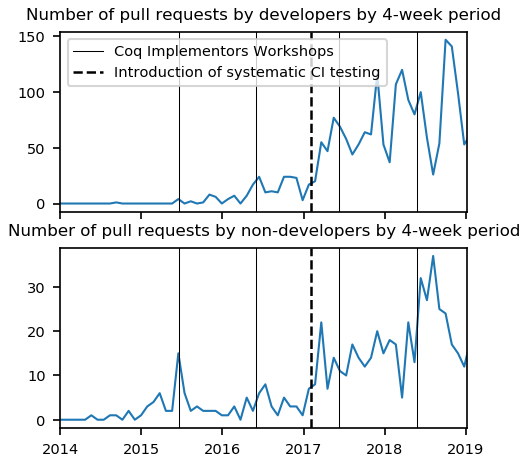

In [26]:
def local():

  ax1 = plt.subplot(2,1,1)
  plt.plot(prs_4W['dev_count'],label='')
  prs_vertical_lines()
  plt.legend()
  plt.title('Number of pull requests by developers by 4-week period')

  plt.setp(ax1.get_xticklabels(), visible=False)

  plt.subplot(2,1,2,sharex=ax1)
  plt.plot(prs_4W['other_count'],label='')
  prs_vertical_lines()
  plt.title('Number of pull requests by non-developers by 4-week period')

  plt.xlim(left=pd.datetime(2014,1,1),right=pd.datetime(2019,1,8))

local()

### Variation of issue creation by month and by hour

#### Average number of issues per month (over years 2008-2017)

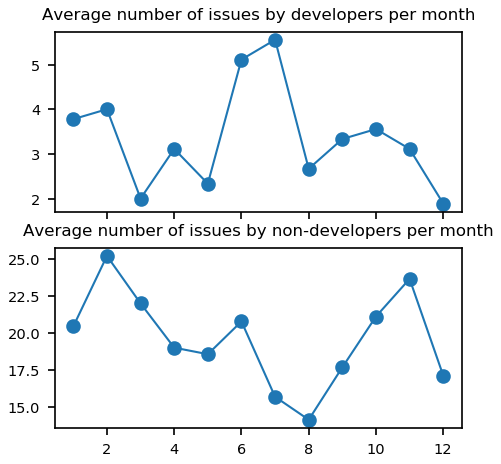

In [27]:
def local():

  issue_by_month_abs = issues[issues.index < pd.datetime(2017,1,1)].resample('M').sum()

  average_issue_nb_by_month = issue_by_month_abs.assign(
      month=issue_by_month_abs.index.month
  ).groupby('month').mean()

  ax1 = plt.subplot(2, 1, 1)
  plt.plot(average_issue_nb_by_month['dev_count'],'-o')
  plt.title('Average number of issues by developers per month')

  plt.setp(ax1.get_xticklabels(), visible=False)

  plt.subplot(2, 1, 2)
  plt.plot(average_issue_nb_by_month['other_count'],'-o')
  plt.title('Average number of issues by non-developers per month')

local()

#### Distribution of issue creation by hour of the day before (since 2016) / after the switch.

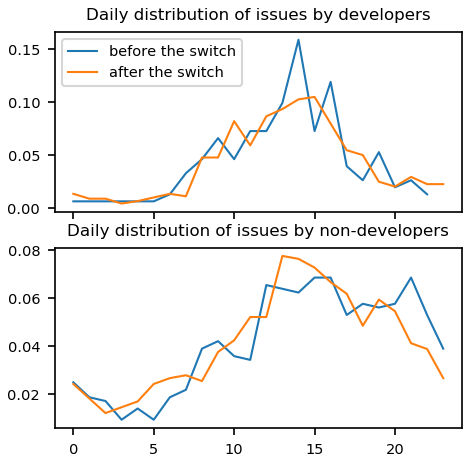

In [28]:
def local():

  def issue_by_hour(cond):
    return issues.assign(hour=issues.index.hour)[cond].groupby('hour').sum()['count'] / len(issues[cond])

  cond_before = (issues['after_switch'] == False) & (issues.index >= pd.datetime(2016,1,1))
  cond_after = issues['after_switch'] == True
  dev_issues = issues['author'].isin(devs)

  ax1 = plt.subplot(2, 1, 1)
  plt.plot(issue_by_hour(cond_before & dev_issues),label='before the switch')
  plt.plot(issue_by_hour(cond_after & dev_issues),label='after the switch')
  plt.title('Daily distribution of issues by developers')
  plt.legend()
  plt.setp(ax1.get_xticklabels(), visible=False)

  plt.subplot(2, 1, 2)
  plt.plot(issue_by_hour(cond_before & ~dev_issues),label='before the switch')
  plt.plot(issue_by_hour(cond_after & ~dev_issues),label='after the switch')
  plt.title('Daily distribution of issues by non-developers')

local()

### Graphs with release dates

In [29]:
def release_vertical_lines():
  for release in releases:
    if release > pd.datetime(2016,1,1):
      line=plt.axvline(x=release,color='black',linestyle="-",lw=0.4)
  line.set_label('major releases')
  plt.axvline(x=switch_date,color='red',linestyle='-',lw=1.2,label='bug tracker switch')

In [30]:
def graph_with_releases(data,variable,title_dev,title_other,filename):

  plot_data = data[data.index >= pd.datetime(2016,1,1)]

  ax1 = plt.subplot(2,1,1)
  plt.plot(plot_data[f'dev_{variable}'],'.',label='')
  release_vertical_lines()
  plt.setp(ax1.get_xticklabels(), visible=False)
  plt.title(title_dev)

  data_before = plot_data[plot_data.index < switch_date][f'dev_{variable}']
  mean_before = data_before.mean()
  data_after = plot_data[plot_data.index >= switch_date][f'dev_{variable}']
  mean_after = data_after.mean()

  print('Developer T-test:')
  print(scipy.stats.ttest_ind(data_before,data_after))

  plt.hlines(mean_before,linestyles='dotted',xmin=pd.datetime(2016,1,1),xmax=switch_date)
  plt.hlines(mean_after,linestyles='dotted',xmin=switch_date,xmax=pd.datetime(2019,3,19))

  plt.legend(loc='upper left')

  ax2 = plt.subplot(2,1,2,sharex=ax1,sharey=ax1)
  plt.plot(plot_data[f'other_{variable}'],'.',label='')
  release_vertical_lines()
  plt.title(title_other)

  data_before = plot_data[plot_data.index < switch_date][f'other_{variable}']
  mean_before = data_before.mean()
  data_after = plot_data[plot_data.index >= switch_date][f'other_{variable}']
  mean_after = data_after.mean()

  print('Non-developer T-test:')
  print(scipy.stats.ttest_ind(data_before,data_after))

  plt.hlines(mean_before,linestyles='dotted',xmin=pd.datetime(2016,1,1),xmax=switch_date)
  plt.hlines(mean_after,linestyles='dotted',xmin=switch_date,xmax=pd.datetime(2019,3,19))

  #plt.xlim(left=pd.datetime(2016,1,30),right=pd.datetime(2019,4,5))

  less_ticks(ax2)

  plt.savefig(filename)

In [31]:
def average(data,group_by):
  grouped = data.groupby(group_by).agg({
      'count':'mean',
      'dev_count':'mean',
      'other_count':'mean',
      'author':'mean',
      'dev_author':'mean',
      'other_author':'mean',
      'new':'mean',
      'date_min':'min',
      'date_max':'max'
  })
  return grouped.assign(
      date=(grouped['date_min'] + (grouped['date_max'] - grouped['date_min']) / 2)
  ).set_index('date')

#### Number of issues

Developer T-test:
Ttest_indResult(statistic=-7.763355524694665, pvalue=1.6592619685599298e-09)
Non-developer T-test:
Ttest_indResult(statistic=-4.721277775516206, pvalue=2.8651603657679603e-05)


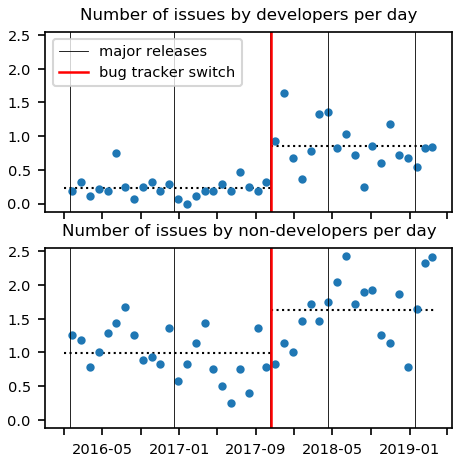

In [32]:
graph_with_releases(
    average(issues_1D,'reldate_4W'),
    'count',
    'Number of issues by developers per day',
    'Number of issues by non-developers per day',
    '../article/bug_nb_with_releases.eps'
)

Average number of issues per day by developers / non-developers since 2016:

In [33]:
issues_1D[(issues_1D).index >= pd.datetime(2016,1,1)]['dev_count'].mean()

0.5021312872975278

In [34]:
issues_1D[(issues_1D).index >= pd.datetime(2016,1,1)]['other_count'].mean()

1.248934356351236

#### Number of reporters

Developer T-test:
Ttest_indResult(statistic=-8.170770250774943, pvalue=4.645678743026237e-10)
Non-developer T-test:
Ttest_indResult(statistic=-5.634593398549191, pvalue=1.5415494559856797e-06)


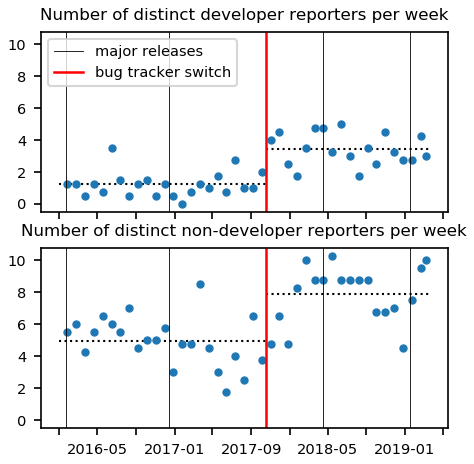

In [35]:
graph_with_releases(
    average(issues_1W,'reldate_4W'),
    'author',
    'Number of distinct developer reporters per week',
    'Number of distinct non-developer reporters per week',
    '../article/reporters_with_releases.eps'
)

Average number of distinct developer / non-developer reporters per week:

In [36]:
issues_1W[(issues_1W).index >= pd.datetime(2016,1,1)]['dev_author'].mean()

2.179640718562874

In [37]:
issues_1W[(issues_1W).index >= pd.datetime(2016,1,1)]['other_author'].mean()

6.149700598802395

#### Number of new reporters

T-test
Ttest_indResult(statistic=-3.068093271453201, pvalue=0.003808379790477981)


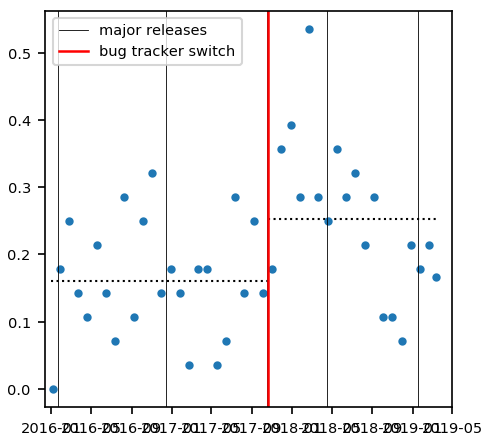

In [38]:
def local():
  plot_data = average(issues_1D[(issues_1D).index >= pd.datetime(2016,1,1)],'reldate_4W')

  plt.xlim(left=pd.datetime(2015,12,15),right=pd.datetime(2019,5,1))

  plt.plot(plot_data['new'],'.',label='')
  release_vertical_lines()
  plt.legend(loc='upper left')

  data_before = plot_data[plot_data.index < switch_date]['new']
  mean_before = data_before.mean()
  data_after = plot_data[plot_data.index >= switch_date]['new']
  mean_after = data_after.mean()

  print('T-test')
  print(scipy.stats.ttest_ind(data_before,data_after))

  plt.hlines(mean_before,linestyles='dotted',xmin=pd.datetime(2016,1,1),xmax=switch_date)
  plt.hlines(mean_after,linestyles='dotted',xmin=switch_date,xmax=pd.datetime(2019,3,19))

local()

#### Number of comments

Developer T-test:
Ttest_indResult(statistic=-6.929463930228082, pvalue=2.3515872046232636e-08)
Non-developer T-test:
Ttest_indResult(statistic=-6.589475991014044, pvalue=7.023938389839209e-08)


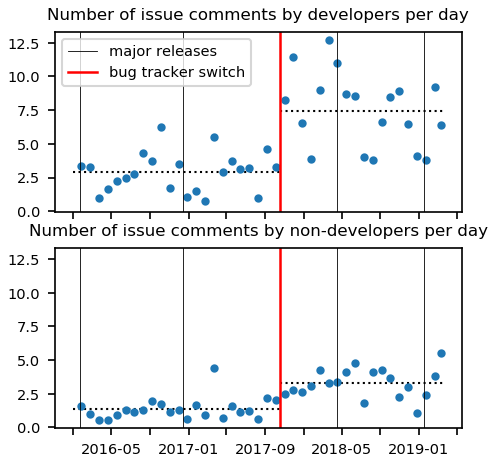

In [39]:
graph_with_releases(
    average(comments_1D,'reldate_4W'),
    'count',
    'Number of issue comments by developers per day',
    'Number of issue comments by non-developers per day',
    '../article/comments_with_releases.eps'
)

Average number of comments per day by developers / non-developers since 2016:

In [40]:
comments_1D[(comments_1D).index >= pd.datetime(2016,1,1)]['dev_count'].mean()

4.915601023017903

In [41]:
comments_1D[(comments_1D).index >= pd.datetime(2016,1,1)]['other_count'].mean()

2.1892583120204603

#### Number of commentators

Developer T-test:
Ttest_indResult(statistic=-6.528387217308541, pvalue=8.554763049810927e-08)
Non-developer T-test:
Ttest_indResult(statistic=-10.195256385362581, pvalue=1.102479965049244e-12)


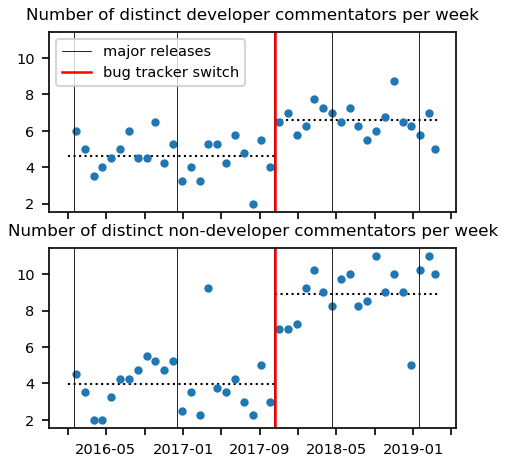

In [42]:
graph_with_releases(
    average(comments_1W,'reldate_4W'),
    'author',
    'Number of distinct developer commentators per week',
    'Number of distinct non-developer commentators per week',
    '../article/commentators_with_releases.eps'
)

Average number of distinct developer / non-developer commentators per week since 2016:

In [43]:
comments_1W[(comments_1W).index >= pd.datetime(2016,1,1)]['dev_author'].mean()

5.508982035928144

In [44]:
comments_1W[(comments_1W).index >= pd.datetime(2016,1,1)]['other_author'].mean()

6.125748502994012

#### Number of new commentators

T-test
Ttest_indResult(statistic=-7.0209798978313644, pvalue=1.5393337404181516e-08)


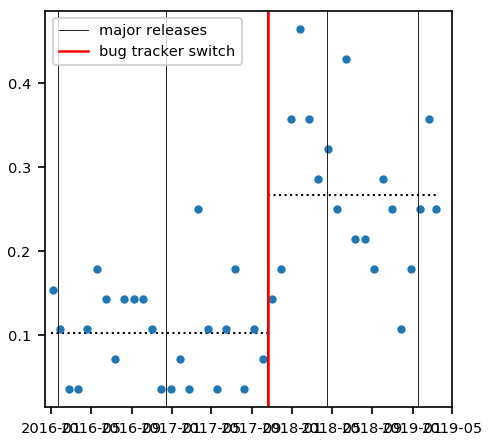

In [45]:
def local():
  plot_data = average(comments_1D[(comments_1D).index >= pd.datetime(2016,1,1)],'reldate_4W')

  plt.xlim(left=pd.datetime(2015,12,15),right=pd.datetime(2019,5,1))

  plt.plot(plot_data['new'],'.',label='')
  release_vertical_lines()
  plt.legend(loc='upper left')

  data_before = plot_data[plot_data.index < switch_date]['new']
  mean_before = data_before.mean()
  data_after = plot_data[plot_data.index >= switch_date]['new']
  mean_after = data_after.mean()

  print('T-test')
  print(scipy.stats.ttest_ind(data_before,data_after))

  plt.hlines(mean_before,linestyles='dotted',xmin=pd.datetime(2016,1,1),xmax=switch_date)
  plt.hlines(mean_after,linestyles='dotted',xmin=switch_date,xmax=pd.datetime(2019,3,19))

local()

#### Commenting rate over time: bug / pull request comparison

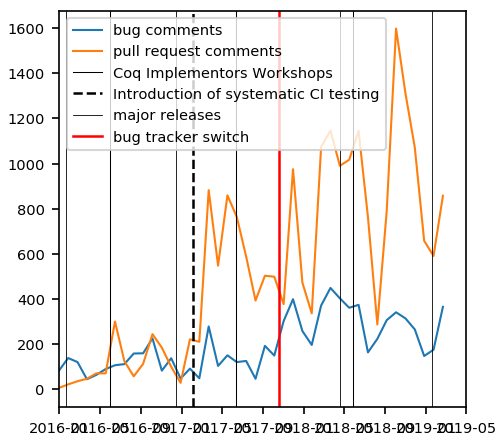

In [46]:
def local():

  plt.plot(comments_4W['count'],label='bug comments')
  plt.plot(pr_comments_4W['count'],label='pull request comments')
  prs_vertical_lines()
  release_vertical_lines()
  plt.xlim(left=pd.datetime(2016,1,1),right=pd.datetime(2019,5,1))
  plt.legend()

local()

#### Number of distinct developer commentators : bug / pull request comparison

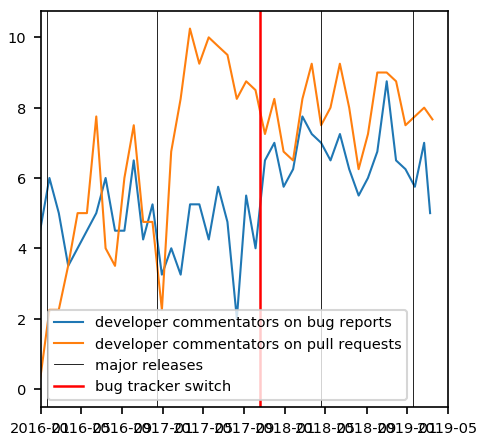

In [47]:
def local():

  plt.plot(average(comments_1W,'reldate_4W')['dev_author'],label='developer commentators on bug reports')
  plt.plot(average(pr_comments_1W,'reldate_4W')['dev_author'],label='developer commentators on pull requests')
  #prs_vertical_lines()
  release_vertical_lines()
  plt.xlim(left=pd.datetime(2016,1,1),right=pd.datetime(2019,5,1))
  plt.legend()

local()

### Number of issues reported by individual developers

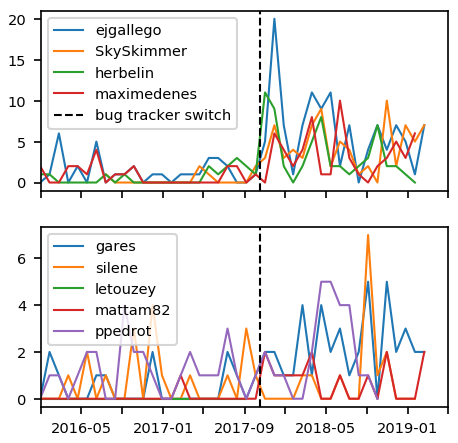

In [48]:
def local():

  def reporter_graph(author):
    dev_issues_4W = group_by_reldate(df_with_fake_elements(issues[
        (issues['author'] == author)
    ]),'_4W')
    plt.plot(dev_issues_4W['count'],'-',label=author)

  ax1 = plt.subplot(2,1,1)
  for reporter in ['ejgallego','SkySkimmer','herbelin','maximedenes']:
    reporter_graph(reporter)
  plt.axvline(x=switch_date,linestyle='--',color='black',label='bug tracker switch')
  plt.setp(ax1.get_xticklabels(), visible=False)
  plt.legend(loc='upper left')

  ax2 = plt.subplot(2,1,2,sharex=ax1)
  for reporter in ['gares','silene','letouzey','mattam82','ppedrot']:
    reporter_graph(reporter)
  plt.axvline(x=switch_date,linestyle='--',color='black',label='')
  plt.legend(loc='upper left')

  plt.xlim(left=pd.datetime(2016,1,1),right=pd.datetime(2019,5,1))
  
  less_ticks(ax2)
  
  #plt.savefig('bugs_individual_devs.png')

local()

### Biggest reporters (period of 40 weeks before to 40 weeks after the switch)

In [49]:
def local():

  issues_grouped_by_author = issues[
      (issues['reldate_4W'] >= -10) &
      (issues['reldate_4W'] < 10)
  ].groupby('author').sum().sort_values(
      'count',
      ascending=False
  )

  return issues_grouped_by_author.assign(
      issues_before=issues_grouped_by_author['count']-issues_grouped_by_author['after_switch'].astype(int),
      issues_after=issues_grouped_by_author['after_switch'].astype(int)
  )[['issues_before','issues_after']].head(10)

local()

,issues_before,issues_after
author,,
ejgallego,12,80
RalfJung,20,48
herbelin,11,42
SkySkimmer,5,47
tchajed,34,11
maximedenes,5,39
ppedrot,11,24
andres-erbsen,0,28
gares,4,21


### Biggest commentators (period of 40 weeks before to 40 weeks after the switch)

In [50]:
def local():

  comments_grouped_by_author = comments[
      (comments['reldate_4W'] >= -10) &
      (comments['reldate_4W'] < 10)
  ].groupby('author').sum().sort_values(
      'count',
      ascending=False
  )

  return comments_grouped_by_author.assign(
      comments_before=comments_grouped_by_author['count']-comments_grouped_by_author['after_switch'].astype(int),
      comments_after=comments_grouped_by_author['after_switch'].astype(int)
  )[['comments_before','comments_after']].head(10)

local()

,comments_before,comments_after
author,,
ejgallego,280,754
herbelin,153,321
maximedenes,88,364
ppedrot,84,266
SkySkimmer,18,297
gares,44,198
psteckler,116,91
RalfJung,76,125
mattam82,33,119


## Main results

In this section, we do (linear) Regressions in Discontinuity analyses on a time window of 175 days (25 weeks) before and after the switch, for our four main outcomes. For number of reports and number of comments, we use 1-day periods. For number of distrinct reporters and number of distinct commenters, we use one week periods. In addition we also include in this notebook the results for the number of new bug reporters and commentators (with one day periods).

Note that, to help readbility of the graphs, the individual points represented are two-week means of the data used for the regression. The regression lines presented still use the full dataset.

In [51]:
def select_periods(df,period_nb):
  return df[
      (df['reldate'] >= -period_nb) &
      (df['reldate'] < period_nb)
  ]

def rd(data,variable,degree,cluster_var=None,display=True):
  robustargs = {'cov_type':'HC1'} if cluster_var is None else {'cov_type':'cluster','cov_kwds':{'groups':data[cluster_var]}}
  formula = variable
  formula += ' ~ after_switch'
  if degree >= 1:
    formula += ' + reldate + after_switch*reldate'
  if degree >= 2:
    formula += ' + reldate_square + after_switch*reldate_square'
  
  results = smf.ols(
      formula=formula,
      data=data.assign(
          reldate_square=data['reldate']*data['reldate']
      )
  ).fit(**robustargs)
    
  def stars(p):
    if p < 0.001:
      return '***'
    elif p < 0.01:
      return '** '
    elif p < 0.05:
      return '*  '
    else:
      return '   '
  
  values = list(zip(*[
      results.params,
      map(stars,results.pvalues),
      results.bse,
      results.pvalues
  ]))
  
  #print(results.model.exog_names)
  
  #table = '<pre>'
  table = ''
  table += f'Outcome variable:\t{variable}\n'
  table += f'No of observations:\t{results.nobs}\n'
  table += '                      \tcoef\t\tstd err\t\tP>|t|\n'
  table += '-----------------------------------------------------------------\n'
  table += 'after switch          \t %.3g %s  \t(%.3g)   \t%.3g\n' % tuple(values[1])
  if degree >= 1:
    table += 'after switch*reldate\t %.3g %s  \t(%.3g)   \t%.3g\n' % tuple(values[3])
    table += 'reldate               \t %.3g %s  \t(%.3g)   \t%.3g\n' % tuple(values[2])
  if degree >= 2:
    table += 'after switch*reldate_sq %.3g %s  \t(%.3g)   \t%.3g\n' % tuple(values[5])
    table += 'reldate_sq        \t %.3g %s  \t(%.3g)   \t%.3g\n' % tuple(values[4])
  table += 'constant              \t %.3g %s  \t(%.3g)   \t%.3g' % tuple(values[0])
  table += '\n\n'
  #table += '</pre><br><br>'
  
  #display(HTML(table))

  if display:
    print(table)
  
  return results, results.params[1], results.pvalues[1]

def plot_rd_line(index,results,color,label=''):
  periods=len(index)//2
  plt.plot(index[:periods],results.predict()[:periods],color=color)
  plt.plot(index[periods:],results.predict()[periods:],color=color,label=label)

def plot_conf_int(index,results,color,label=''):
  periods=len(index)//2
  _, data, _ = summary_table(results, alpha=0.05)
  
  # Get the confidence intervals of the model
  low_CI, upper_CI = data[:,4:6].T
  
  # Shade the confidence interval
  plt.fill_between(index[:periods],low_CI[:periods],upper_CI[:periods],color=color,alpha=0.2,label=label)
  plt.fill_between(index[periods:],low_CI[periods:],upper_CI[periods:],color=color,alpha=0.2,label=label)

In [52]:
def hetero_analysis(rd_data,variable,label_all,label_dev,label_others,periods,degree=1,filename=None,cluster_var=None,switch_date=switch_date):

  rd_data = select_periods(rd_data,periods)
  
  plot_data = average(rd_data,'reldate_2W')

  dev_variable = f'dev_{variable}'
  other_variable = f'other_{variable}'
  

  degree_all = degree
  degree_devs = degree
  degree_others = degree
  
  everyone, _, _ = rd(rd_data,variable,degree=degree_all,cluster_var=cluster_var,display=True)
  devs, _, _ = rd(rd_data,dev_variable,degree=degree_devs,cluster_var=cluster_var,display=True)
  others, _, _ = rd(rd_data,other_variable,degree=degree_others,cluster_var=cluster_var,display=True)
  
  _, ax = plt.subplots()
  
  plot_rd_line(rd_data.index,devs,'indigo')
  plot_conf_int(rd_data.index,devs,'indigo')
  plt.plot(plot_data[dev_variable],'.',color='indigo',label=label_dev)
  
  plot_rd_line(rd_data.index,others,'#ff8c00')
  plot_conf_int(rd_data.index,others,'#ff8c00')
  plt.plot(plot_data[other_variable],'.',color='#ff8c00',label=label_others)
  
  plt.axvline(x=switch_date,color='black', linestyle='--')
  plt.legend()

  less_ticks(ax)

  if not filename is None:
    plt.savefig(f'{filename}.png')

  plt.show()
  
  # Now let's write some LaTeX files with these tables
  
  def get_param(results, i):
    try:
      param = '%.3g' % results.params[i]
      p = results.pvalues[i]
    except IndexError:
      return ''
    if p < 0.001:
      return '\\textbf{%s***}' % param
    elif p < 0.01:
      return '\\textbf{%s**}' % param
    elif p < 0.05:
      return '\\textbf{%s*}' % param
    else:
      return param
  
  def get_bse(results,i):
    try:
      return '(%.3g)' % results.bse[i]
    except IndexError:
      return ''
  
  def row(name1,name2,i):
    return '%s & %s & %s & %s \\\\\n' % (
        name1,
        get_param(everyone,i),
        get_param(devs,i),
        get_param(others,i),
    ) + '%s & %s & %s & %s \\\\\n' % (
        name2,
        get_bse(everyone,i),
        get_bse(devs,i),
        get_bse(others,i)
    ) + '\\hline\n'
  
  latex = """\\begin{tabular}{|r|c|c|c|}
\\hline
&  Total & Developers & Non-developers \\\\
\\hline
"""
  latex += row('$\\mbox{\\emph{After switch}}_p$','',1)
  latex += row('$\\mbox{\\emph{Relative date}}_p$','$\\times \\mbox{\\emph{After switch}}_p$',3)
  latex += row('$\\mbox{\\emph{Relative date}}_p$','',2)
  if degree == 2:
    latex += row('$\\mbox{\\emph{Relative date}}_p^2$','$ \\times \\mbox{\\emph{After switch}}_p$',5)
    latex += row('$\\mbox{\\emph{Relative date}}_p^2$','',4)
  latex += row('Constant','',0)
  latex += 'Observation number & %d & %d & %d \\\\\n' % (
      everyone.nobs,
      devs.nobs,
      others.nobs
  )
  latex += '\\hline\n\\end{tabular}'
  
  if not filename is None:
    with open(f'{filename}.tex', 'w') as f:
      f.write(latex)

def homo_analysis(rd_data,variable,periods,label='',degree=1,cluster_var=None,switch_date=switch_date,display=True):

  rd_data = select_periods(rd_data,periods)
  
  plot_data = average(rd_data,'reldate_2W')

  results, after_switch_param, after_switch_pvalue = rd(rd_data,variable,degree=degree,cluster_var=cluster_var,display=display)
  
  if display:
    
    _, ax = plt.subplots()
  
    plot_rd_line(rd_data.index,results,'black')
    plot_conf_int(rd_data.index,results,'black')
    plt.plot(plot_data[variable],'.',color='black',label=label)

    plt.axvline(x=switch_date,color='black', linestyle='--')
    if label != '':
      plt.legend()

    less_ticks(ax)
  
    plt.show()

  return after_switch_param, after_switch_pvalue

### Number of issues

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.629      	(0.354)   	0.076
after switch*reldate	 0.00114      	(0.00341)   	0.738
reldate               	 0.00305      	(0.00182)   	0.0925
constant              	 1.23 ***  	(0.21)   	5.03e-09


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.73 **   	(0.239)   	0.00228
after switch*reldate	 -0.000383      	(0.00227)   	0.866
reldate               	 -0.00013      	(0.000816)   	0.874
constant              	 0.269 ***  	(0.0809)   	0.000905


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 -0.101      	(0.244)   	0.678
after

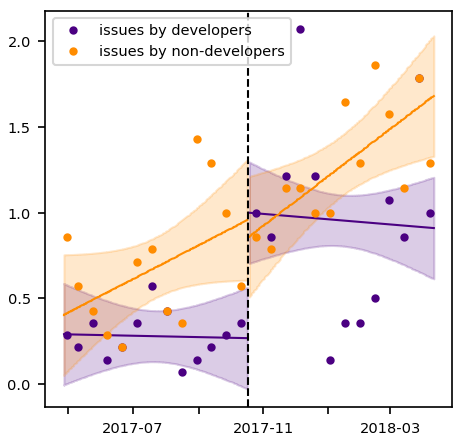

In [53]:
hetero_analysis(
    issues_1D,
    'count',
    'issues by everyone',
    'issues by developers',
    'issues by non-developers',
    periods=175,
    filename='../article/bug_nb_rd'
)

### Number of  reporters

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.17      	(1.68)   	0.196
after switch*reldate	 0.146      	(0.108)   	0.176
reldate               	 0.0608      	(0.0903)   	0.501
constant              	 6.03 ***  	(1.47)   	4e-05


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.92 *    	(0.977)   	0.0493
after switch*reldate	 0.0162      	(0.0648)   	0.803
reldate               	 -0.00462      	(0.0378)   	0.903
constant              	 1.5 **   	(0.579)   	0.00955


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.245      	(1.27)   	0.847
after switch*reldate	 0.13    

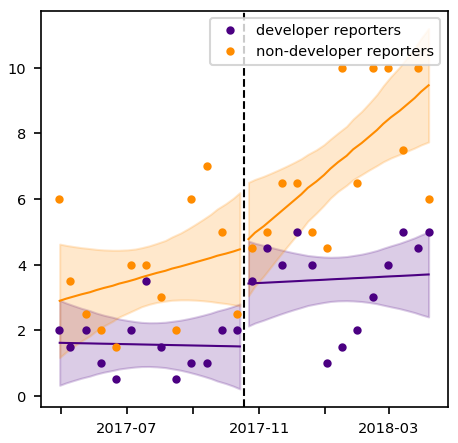

In [54]:
hetero_analysis(
    issues_1W,
    'author',
    'all reporters',
    'developer reporters',
    'non-developer reporters',
    periods=25,
    filename='../article/reporter_nb_rd'
)

### Number of new reporters

Outcome variable:	new
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.0743      	(0.0951)   	0.434
after switch*reldate	 -0.000298      	(0.000934)   	0.75
reldate               	 0.000703      	(0.000553)   	0.204
constant              	 0.216 ***  	(0.0635)   	0.000659




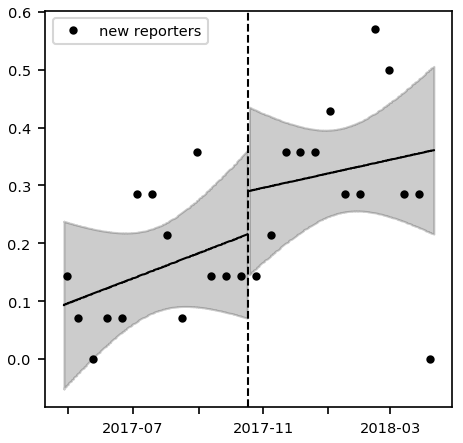

In [55]:
_ = homo_analysis(issues_1D,'new',label='new reporters',periods=175)

### Number of comments

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 5.39 *    	(2.29)   	0.0186
after switch*reldate	 0.0156      	(0.0217)   	0.472
reldate               	 0.00235      	(0.00909)   	0.796
constant              	 4.82 ***  	(1.04)   	3.76e-06


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 4.63 *    	(1.83)   	0.0114
after switch*reldate	 0.0139      	(0.018)   	0.44
reldate               	 -0.00156      	(0.00685)   	0.82
constant              	 3.03 ***  	(0.708)   	1.89e-05


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.76      	(0.729)   	0.297
after switch*reldate	 0

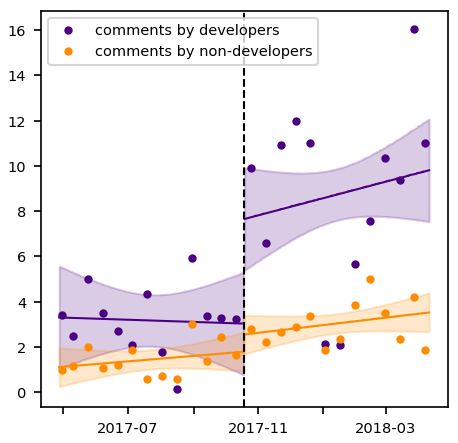

In [56]:
hetero_analysis(
    comments_1D,
    'count',
    'all comments',
    'comments by developers',
    'comments by non-developers',
    periods=175,
    filename='../article/comment_nb_rd'
)

### Number of commentators

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 6.19 ***  	(1.81)   	0.000649
after switch*reldate	 0.205      	(0.118)   	0.0822
reldate               	 -0.0692      	(0.0833)   	0.406
constant              	 7.06 ***  	(1.54)   	4.78e-06


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.53 *    	(1.05)   	0.0155
after switch*reldate	 0.0769      	(0.0641)   	0.23
reldate               	 -0.0469      	(0.0589)   	0.425
constant              	 3.83 ***  	(0.984)   	9.93e-05


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 3.66 **   	(1.17)   	0.00184
after switch*reldate	 

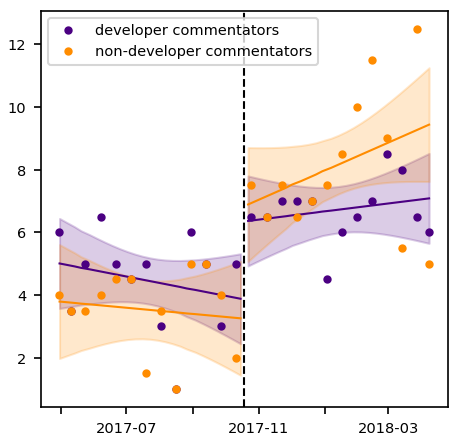

In [57]:
hetero_analysis(
    comments_1W,
    'author',
    'all commentators',
    'developer commentators',
    'non-developer commentators',
    periods=25,
    filename='../article/commentator_nb_rd',
)

### Number of new commentators

Outcome variable:	new
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.124      	(0.0748)   	0.0965
after switch*reldate	 0.000887      	(0.000772)   	0.251
reldate               	 2.46e-05      	(0.000396)   	0.95
constant              	 0.0879 *    	(0.0393)   	0.0252




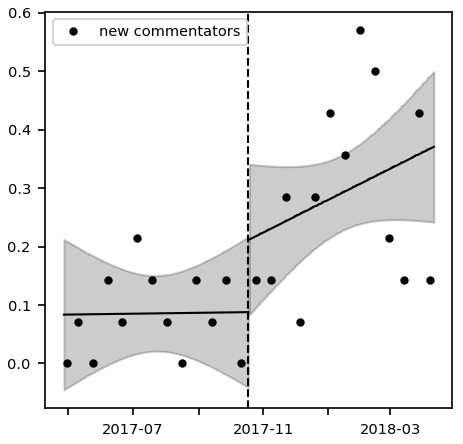

In [58]:
_ = homo_analysis(comments_1D,'new',label='new commentators',periods=175)

## Robustness checks


### Larger time windows

For every outcome variable, we also test linear and quadratic specifications on 511 days (73 weeks).


In [59]:
def robustness_checks(data_main,variable,analysis_type='heterogeneous',weekly_data=False):
  for degree in [1,2]:
    periods = 73 if weekly_data else 511
    display(HTML('<h6>Linear specification</h6' if degree == 1 else '<h6>Quadratic specification</h6>'))
    if analysis_type == 'heterogeneous':
      hetero_analysis(data_main,variable,'all','developers','non-developers',periods=periods,degree=degree)
    else:
      homo_analysis(data_main,variable,periods=periods,degree=degree)

#### Number of issues

Outcome variable:	count
No of observations:	1022.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.53 ***  	(0.213)   	6.47e-13
after switch*reldate	 0.00188 *    	(0.000769)   	0.0144
reldate               	 -0.00149 ***  	(0.000443)   	0.000783
constant              	 0.807 ***  	(0.119)   	1.31e-11


Outcome variable:	dev_count
No of observations:	1022.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.83 ***  	(0.124)   	2.62e-11
after switch*reldate	 -0.000628      	(0.00041)   	0.125
reldate               	 -0.000119      	(0.000196)   	0.543
constant              	 0.206 ***  	(0.05)   	3.65e-05


Outcome variable:	other_count
No of observations:	1022.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.701 ***  	(0.164)   

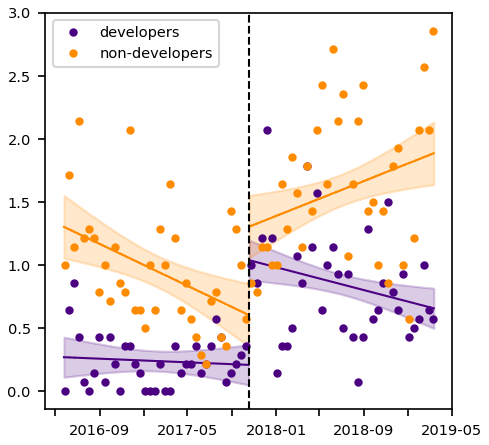

Outcome variable:	count
No of observations:	1022.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.825 **   	(0.316)   	0.00903
after switch*reldate	 0.000888      	(0.003)   	0.767
reldate               	 0.00315      	(0.00177)   	0.0744
after switch*reldate_sq -1.62e-05 **   	(5.93e-06)   	0.00625
reldate_sq        	 9.06e-06 **   	(3.42e-06)   	0.00813
constant              	 1.2 ***  	(0.189)   	1.74e-10


Outcome variable:	dev_count
No of observations:	1022.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.673 ***  	(0.2)   	0.000769
after switch*reldate	 -0.00296      	(0.00168)   	0.0787
reldate               	 0.00196 **   	(0.0007)   	0.00517
after switch*reldate_sq -3.57e-06      	(3.04e-06)   	0.241
reldate_sq        	 4.06e-06 **   	(1.45e-06)   	0.00514
constant              	 0.384 ***  	(0.0736)  

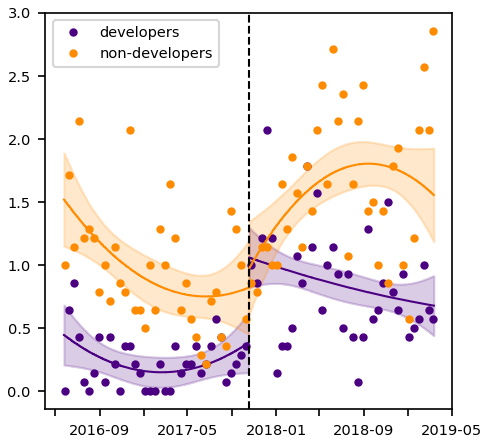

In [60]:
robustness_checks(issues_1D,'count')

#### Number of reporters

Outcome variable:	author
No of observations:	146.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 6.22 ***  	(1.07)   	5.19e-09
after switch*reldate	 0.0342      	(0.0242)   	0.158
reldate               	 -0.031 *    	(0.0151)   	0.0403
constant              	 4.87 ***  	(0.722)   	1.57e-11


Outcome variable:	dev_author
No of observations:	146.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.44 ***  	(0.542)   	6.96e-06
after switch*reldate	 -0.00599      	(0.0122)   	0.624
reldate               	 -0.000216      	(0.00826)   	0.979
constant              	 1.24 ***  	(0.327)   	0.000149


Outcome variable:	other_author
No of observations:	146.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 3.79 ***  	(0.854)   	9.26e-06
after 

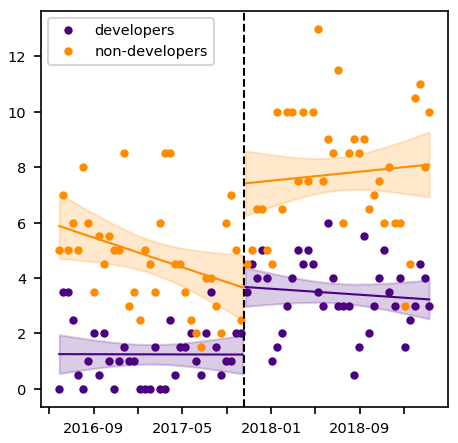

Outcome variable:	author
No of observations:	146.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 3.43 *    	(1.48)   	0.0204
after switch*reldate	 0.0774      	(0.0987)   	0.433
reldate               	 0.0627      	(0.0721)   	0.384
after switch*reldate_sq -0.00317 *    	(0.00136)   	0.0197
reldate_sq        	 0.00127      	(0.000905)   	0.162
constant              	 6.04 ***  	(1.2)   	4.76e-07


Outcome variable:	dev_author
No of observations:	146.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.55      	(0.833)   	0.0625
after switch*reldate	 -0.0894      	(0.0517)   	0.0837
reldate               	 0.0767 *    	(0.031)   	0.0133
after switch*reldate_sq -0.00095      	(0.000679)   	0.162
reldate_sq        	 0.00104 *    	(0.000429)   	0.0154
constant              	 2.2 ***  	(0.503)   	1.21e-05


Outcome varia

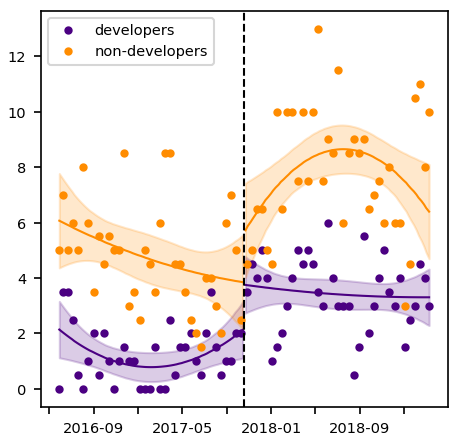

In [61]:
robustness_checks(issues_1W,'author',weekly_data=True)

#### Number of new reporters

Outcome variable:	new
No of observations:	1022.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.212 ***  	(0.0596)   	0.000374
after switch*reldate	 -0.000386 *    	(0.000192)   	0.044
reldate               	 -3.88e-05      	(0.000125)   	0.757
constant              	 0.154 ***  	(0.0366)   	2.42e-05




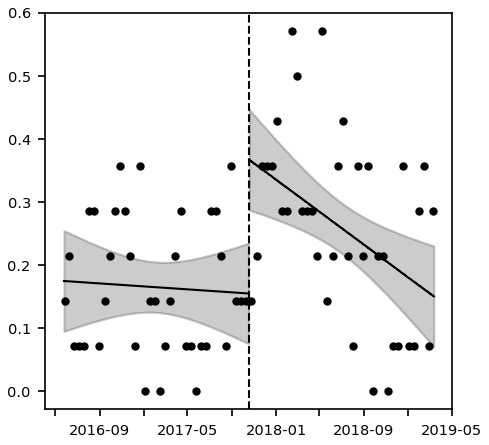

Outcome variable:	new
No of observations:	1022.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.169      	(0.087)   	0.0517
after switch*reldate	 -0.000166      	(0.000769)   	0.829
reldate               	 0.000104      	(0.00051)   	0.839
after switch*reldate_sq -9.89e-07      	(1.44e-06)   	0.494
reldate_sq        	 2.78e-07      	(9.44e-07)   	0.768
constant              	 0.167 **   	(0.0579)   	0.00398




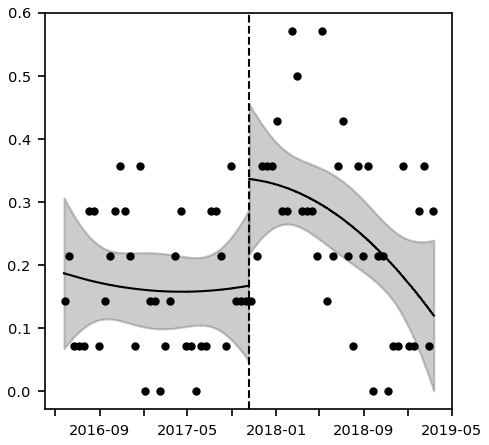

In [62]:
robustness_checks(issues_1D,'new',analysis_type='homogeneous')

#### Number of comments

Outcome variable:	count
No of observations:	1022.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 7.87 ***  	(1.15)   	9.23e-12
after switch*reldate	 -0.00756 *    	(0.00367)   	0.0396
reldate               	 0.000357      	(0.00178)   	0.841
constant              	 4.65 ***  	(0.559)   	9.31e-17


Outcome variable:	dev_count
No of observations:	1022.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 6.2 ***  	(0.933)   	2.93e-11
after switch*reldate	 -0.00632 *    	(0.00299)   	0.0343
reldate               	 -0.000327      	(0.00133)   	0.805
constant              	 2.98 ***  	(0.409)   	3.19e-13


Outcome variable:	other_count
No of observations:	1022.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.67 ***  	(0.382)   	1.26e-05

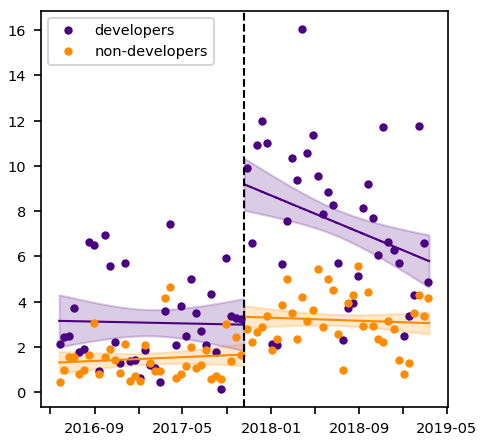

Outcome variable:	count
No of observations:	1022.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 6.93 ***  	(1.88)   	0.000224
after switch*reldate	 -0.000892      	(0.0157)   	0.955
reldate               	 0.00256      	(0.00717)   	0.721
after switch*reldate_sq -2.17e-05      	(2.82e-05)   	0.442
reldate_sq        	 4.31e-06      	(1.24e-05)   	0.729
constant              	 4.83 ***  	(0.886)   	4.95e-08


Outcome variable:	dev_count
No of observations:	1022.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 5.86 ***  	(1.49)   	8.2e-05
after switch*reldate	 -0.00948      	(0.0124)   	0.444
reldate               	 0.00327      	(0.00492)   	0.506
after switch*reldate_sq -7.9e-06      	(2.24e-05)   	0.724
reldate_sq        	 7.03e-06      	(8.66e-06)   	0.417
constant              	 3.29 ***  	(0.606)   	5.63e-08



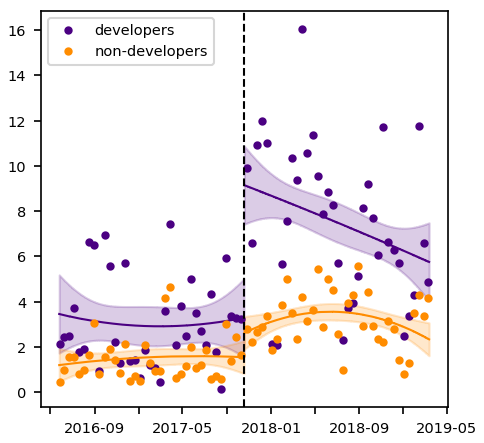

In [63]:
robustness_checks(comments_1D,'count')

#### Number of commentators

Outcome variable:	author
No of observations:	146.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 7.18 ***  	(1.11)   	1e-10
after switch*reldate	 0.0538 *    	(0.0255)   	0.0345
reldate               	 -0.0333      	(0.018)   	0.0646
constant              	 7.62 ***  	(0.846)   	2.1e-19


Outcome variable:	dev_author
No of observations:	146.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.68 ***  	(0.587)   	5.09e-06
after switch*reldate	 0.0114      	(0.0135)   	0.398
reldate               	 -0.0147      	(0.0111)   	0.184
constant              	 4.09 ***  	(0.518)   	2.96e-15


Outcome variable:	other_author
No of observations:	146.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 4.5 ***  	(0.801)   	1.92e-08
after switch*re

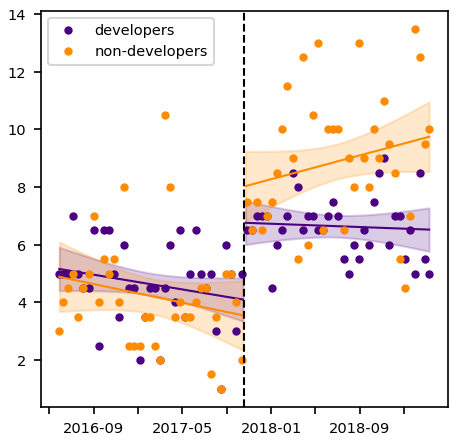

Outcome variable:	author
No of observations:	146.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 6.48 ***  	(1.59)   	4.68e-05
after switch*reldate	 0.16      	(0.1)   	0.11
reldate               	 -0.0564      	(0.0806)   	0.484
after switch*reldate_sq -0.000846      	(0.00133)   	0.524
reldate_sq        	 -0.000312      	(0.000992)   	0.753
constant              	 7.33 ***  	(1.35)   	5.84e-08


Outcome variable:	dev_author
No of observations:	146.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.12 *    	(0.902)   	0.0185
after switch*reldate	 0.0106      	(0.0506)   	0.835
reldate               	 0.00839      	(0.0443)   	0.85
after switch*reldate_sq -0.000621      	(0.000636)   	0.329
reldate_sq        	 0.000312      	(0.000528)   	0.555
constant              	 4.37 ***  	(0.827)   	1.24e-07


Outcome varia

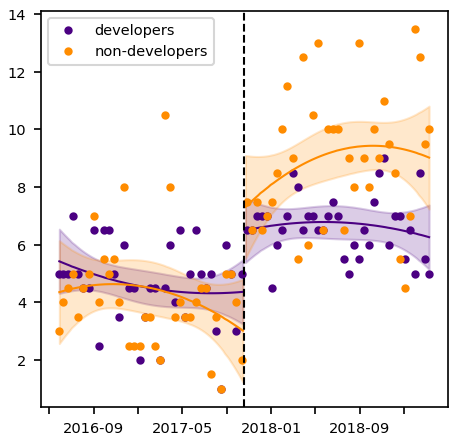

In [64]:
robustness_checks(comments_1W,'author',weekly_data=True)

#### Number of new commentators

Outcome variable:	new
No of observations:	1022.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.219 ***  	(0.0547)   	6.14e-05
after switch*reldate	 -7.46e-05      	(0.00018)   	0.678
reldate               	 -7.01e-05      	(9.53e-05)   	0.462
constant              	 0.0838 **   	(0.028)   	0.00275




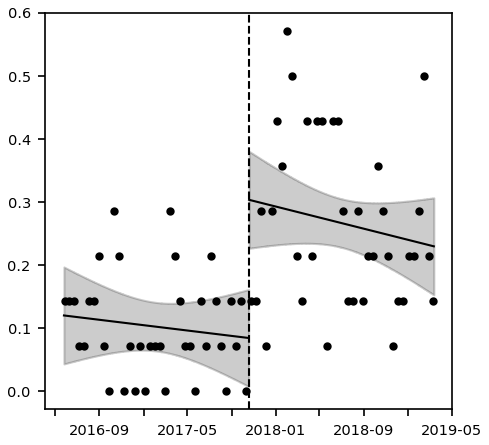

Outcome variable:	new
No of observations:	1022.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.18 *    	(0.0729)   	0.0134
after switch*reldate	 0.000184      	(0.000696)   	0.792
reldate               	 2.98e-05      	(0.000339)   	0.93
after switch*reldate_sq -8.97e-07      	(1.38e-06)   	0.515
reldate_sq        	 1.95e-07      	(6.69e-07)   	0.771
constant              	 0.0924 *    	(0.0376)   	0.014




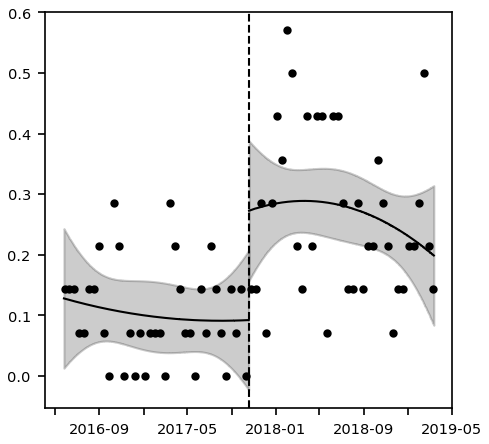

In [65]:
robustness_checks(comments_1D,'new',analysis_type='homogeneous')

### Donut RDs

To account for anticipation / adaptation effects, we test our main specification without the two weeks before and after the bug tracker switch.

In [66]:
def donut(df):
    return df[(df['reldate_2W'] < -1) | (df['reldate_2W'] > 0)]

#### Number of issues

Outcome variable:	count
No of observations:	322.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.512      	(0.394)   	0.194
after switch*reldate	 -8.63e-05      	(0.00369)   	0.981
reldate               	 0.00417 *    	(0.00207)   	0.0442
constant              	 1.36 ***  	(0.246)   	3.22e-08


Outcome variable:	dev_count
No of observations:	322.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.754 **   	(0.248)   	0.00239
after switch*reldate	 -9.78e-05      	(0.00234)   	0.967
reldate               	 -0.000357      	(0.00083)   	0.668
constant              	 0.239 **   	(0.0812)   	0.00319


Outcome variable:	other_count
No of observations:	322.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 -0.242      	(0.29)   	0.404
aft

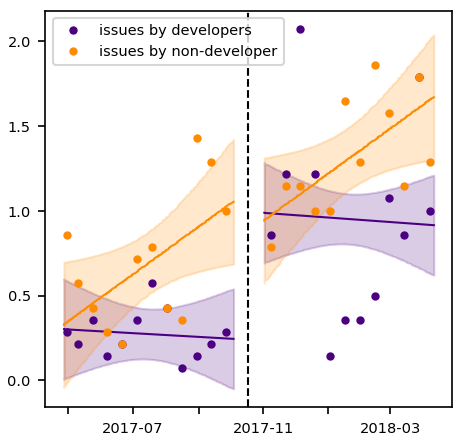

In [67]:
hetero_analysis(
    donut(issues_1D),
    'count',
    'issues by everyone',
    'issues by developers',
    'issues by non-developer',
    periods=175
)

#### Number of  reporters

Outcome variable:	author
No of observations:	46.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.59      	(1.69)   	0.348
after switch*reldate	 0.0998      	(0.109)   	0.36
reldate               	 0.101      	(0.0826)   	0.223
constant              	 6.72 ***  	(1.31)   	3.14e-07


Outcome variable:	dev_author
No of observations:	46.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.05 *    	(0.941)   	0.0297
after switch*reldate	 0.0306      	(0.0624)   	0.623
reldate               	 -0.0148      	(0.0334)   	0.657
constant              	 1.31 **   	(0.481)   	0.00629


Outcome variable:	other_author
No of observations:	46.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 -0.456      	(1.31)   	0.727
after switch*reldate	 0.069

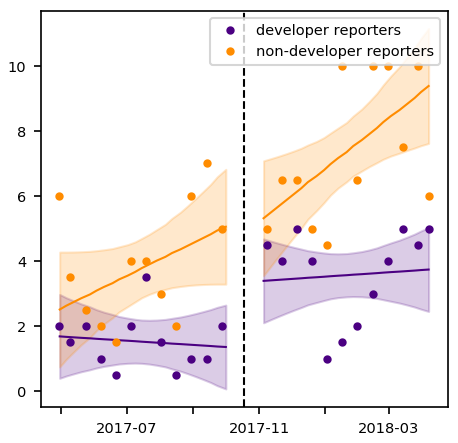

In [68]:
hetero_analysis(
    donut(issues_1W),
    'author',
    'all reporters',
    'developer reporters',
    'non-developer reporters',
    periods=25
)

#### Number of new reporters

Outcome variable:	new
No of observations:	322.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.108      	(0.12)   	0.365
after switch*reldate	 -0.00108      	(0.0011)   	0.325
reldate               	 0.000952      	(0.000665)   	0.152
constant              	 0.246 **   	(0.0793)   	0.00193




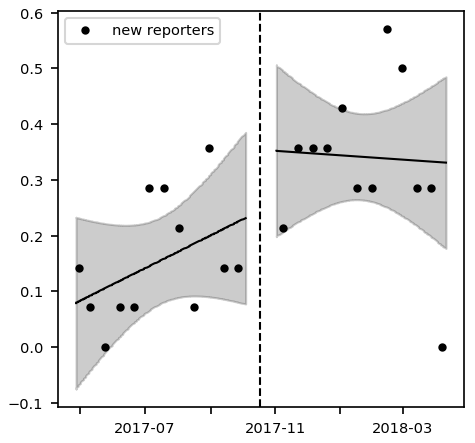

In [69]:
_ = homo_analysis(donut(issues_1D),'new',label='new reporters',periods=175)

#### Number of comments

Outcome variable:	count
No of observations:	322.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 4.32      	(2.35)   	0.0666
after switch*reldate	 0.0247      	(0.0221)   	0.264
reldate               	 0.00242      	(0.0103)   	0.814
constant              	 4.82 ***  	(1.22)   	7.61e-05


Outcome variable:	dev_count
No of observations:	322.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 3.69      	(1.95)   	0.0586
after switch*reldate	 0.0228      	(0.019)   	0.23
reldate               	 -0.00194      	(0.00835)   	0.817
constant              	 2.98 **   	(0.916)   	0.00115


Outcome variable:	other_count
No of observations:	322.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.624      	(0.723)   	0.388
after switch*reldate	 0

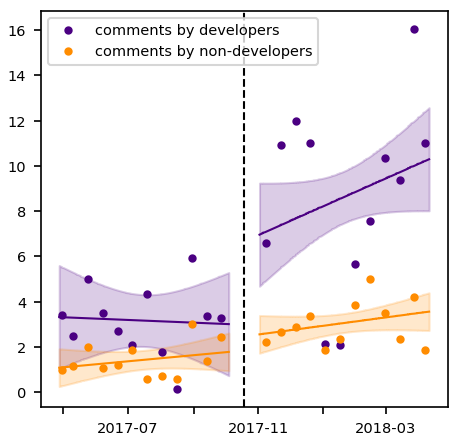

In [70]:
hetero_analysis(
    donut(comments_1D),
    'count',
    'all comments',
    'comments by developers',
    'comments by non-developers',
    periods=175
)

#### Number of commentators

Outcome variable:	author
No of observations:	46.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 5.79 *    	(2.35)   	0.0137
after switch*reldate	 0.215      	(0.146)   	0.139
reldate               	 -0.0623      	(0.103)   	0.545
constant              	 7.17 ***  	(1.94)   	0.000225


Outcome variable:	dev_author
No of observations:	46.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.92 *    	(1.27)   	0.0219
after switch*reldate	 0.106      	(0.0755)   	0.161
reldate               	 -0.0721      	(0.0688)   	0.294
constant              	 3.38 **   	(1.18)   	0.00428


Outcome variable:	other_author
No of observations:	46.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.87      	(1.51)   	0.0568
after switch*reldate	 0.11   

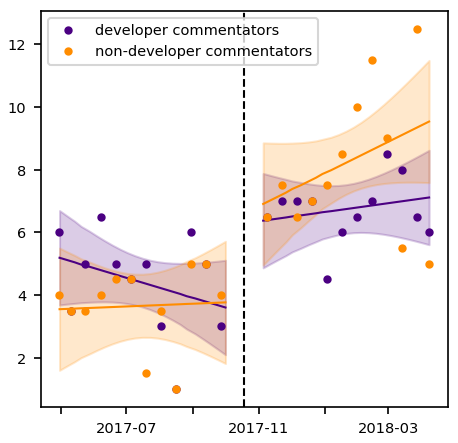

In [71]:
hetero_analysis(
    donut(comments_1W),
    'author',
    'all commentators',
    'developer commentators',
    'non-developer commentators',
    periods=25
)

#### Number of new commentators

Outcome variable:	new
No of observations:	322.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.119      	(0.096)   	0.216
after switch*reldate	 0.000313      	(0.00091)   	0.731
reldate               	 0.000334      	(0.000493)   	0.499
constant              	 0.125 *    	(0.0537)   	0.0201




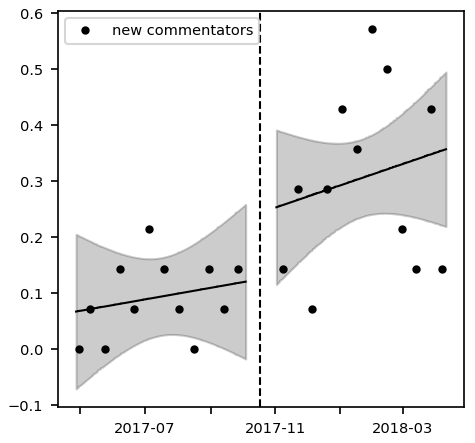

In [72]:
_ = homo_analysis(donut(comments_1D),'new',label='new commentators',periods=175)

### Placebo

In [73]:
def placebo(data,dates):
  variables = ['count','dev_count','other_count','author','dev_author','other_author','new']
  after_switch_coefs = pd.DataFrame(index=dates, columns=variables)
  after_switch_pvalues = pd.DataFrame(index=dates, columns=variables)
  for date in dates:
    _,data_1D,data_1W,_,_ = df_1D_1W_2W_4W(data,switch_date=date)
    for variable in ['count','dev_count','other_count','new']:
      coef, pvalue = homo_analysis(data_1D,variable,periods=175,switch_date=date,display=False)
      after_switch_coefs.at[date,variable] = coef
      after_switch_pvalues.at[date,variable] = pvalue
    for variable in ['author','dev_author','other_author']:
      coef, pvalue = homo_analysis(data_1W,variable,periods=25,switch_date=date,display=False)
      after_switch_coefs.at[date,variable] = coef
      after_switch_pvalues.at[date,variable] = pvalue
  return after_switch_coefs, after_switch_pvalues

#### With release dates

Since the Coq bug tracker switch was concommittant with a new release of Coq, we examine the effect of other releases with donut RDs.

In [74]:
placebo_issues_releases = placebo(issues,dates=releases[:5]+[pd.datetime(2017,10,18)]+[releases[6]])
placebo_comments_releases = placebo(comments,dates=releases[:5]+[pd.datetime(2017,10,18)]+[releases[6]])

##### Number of issues by developers

In [75]:
def local():
    coefs, pvalues = placebo_issues_releases[0]['dev_count'], placebo_issues_releases[1]['dev_count']
    return pd.DataFrame(data={'dates':coefs.index, 'coefs':coefs, 'pvalues': pvalues})

local()

,dates,coefs,pvalues
2009-02-15,2009-02-15,-0.024841,0.564875
2010-10-14,2010-10-14,-0.0501747,0.317603
2012-08-12,2012-08-12,-0.00396328,0.939526
2016-01-21,2016-01-21,-0.0354545,0.771091
2016-12-14,2016-12-14,-0.23225,0.0363268
2017-10-18,2017-10-18,0.730325,0.00228025
2018-04-17,2018-04-17,0.219037,0.392479


##### Number of developer reporters

In [76]:
def local():
    coefs, pvalues = placebo_issues_releases[0]['dev_author'], placebo_issues_releases[1]['dev_author']
    return pd.DataFrame(data={'dates':coefs.index, 'coefs':coefs, 'pvalues': pvalues})

local()

,dates,coefs,pvalues
2009-02-15,2009-02-15,-0.210769,0.461954
2010-10-14,2010-10-14,-0.146154,0.630883
2012-08-12,2012-08-12,-0.299231,0.316318
2016-01-21,2016-01-21,-0.135385,0.763668
2016-12-14,2016-12-14,-0.733077,0.103487
2017-10-18,2017-10-18,1.92154,0.0492583
2018-04-17,2018-04-17,0.91,0.321132


##### Number of comments by developers

In [77]:
def local():
    coefs, pvalues = placebo_comments_releases[0]['dev_count'], placebo_comments_releases[1]['dev_count']
    return pd.DataFrame(data={'dates':coefs.index, 'coefs':coefs, 'pvalues': pvalues})

local()

,dates,coefs,pvalues
2009-02-15,2009-02-15,-0.862779,0.0435666
2010-10-14,2010-10-14,-1.11406,0.0110807
2012-08-12,2012-08-12,-0.623206,0.22995
2016-01-21,2016-01-21,0.20114,0.783577
2016-12-14,2016-12-14,-3.0394,0.000201931
2017-10-18,2017-10-18,4.62753,0.0114078
2018-04-17,2018-04-17,-1.20609,0.524455


##### Number of non-developer commentators

In [78]:
def local():
    coefs, pvalues = placebo_comments_releases[0]['other_author'], placebo_comments_releases[1]['other_author']
    return pd.DataFrame(data={'dates':coefs.index, 'coefs':coefs, 'pvalues': pvalues})

local()

,dates,coefs,pvalues
2009-02-15,2009-02-15,-0.607692,0.465808
2010-10-14,2010-10-14,0.653077,0.398646
2012-08-12,2012-08-12,0.946923,0.239999
2016-01-21,2016-01-21,-1.73462,0.0490729
2016-12-14,2016-12-14,-1.84615,0.128279
2017-10-18,2017-10-18,3.65615,0.00183604
2018-04-17,2018-04-17,0.462308,0.81691


##### New commentators

In [79]:
def local():
    coefs, pvalues = placebo_comments_releases[0]['new'], placebo_comments_releases[1]['new']
    return pd.DataFrame(data={'dates':coefs.index, 'coefs':coefs, 'pvalues': pvalues})

local()

,dates,coefs,pvalues
2009-02-15,2009-02-15,0.0255329,0.715452
2010-10-14,2010-10-14,0.0472481,0.309678
2012-08-12,2012-08-12,-0.0518495,0.290483
2016-01-21,2016-01-21,-0.0222123,0.709942
2016-12-14,2016-12-14,0.00085983,0.986499
2017-10-18,2017-10-18,0.124261,0.0965475
2018-04-17,2018-04-17,0.0367913,0.781558


### Impact of individual developers

In the following, we ensure that the results for developers are robust when we remove a single developer at a time.

We can see that the results on the number of issues are robust with any developer removed.

The results on the number of weekly distinct reporters are not robust to the removal of the following four developers: ejgallego, SkySkimmer, herbelin, and mattam82. Given the change in the estimated values of the jump, this shows that this four developers were each responsible for an increase of 0.4 to 0.6 in the number of distinct weekly reporters, which virtually adds up to the estimated value of the jump when these four developers are present.

Conversely, there is a single developer (silene) whose removal increases the estimated value of the jump of 0.44. When we interviewed him, he said that the switch of bug tracker required adapting to a new workflow, but this has happened at a period when he was to busy to allocate time to adapt, which resulted in him reducing his activity.

In [92]:
issues_1D = {}
issues_1W = {}
comments_1D = {}
comments_1W = {}
active_non_excluded_devs = ['ejgallego', 'gares', 'SkySkimmer', 'silene', 'herbelin', 'mattam82', 'maximedenes', 'letouzey', 'ppedrot']
for dev in active_non_excluded_devs:
  _,issues_1D[dev],issues_1W[dev],_,_ = df_1D_1W_2W_4W(issues[issues['author'].isin(devs)],in_devs=lambda author: author != dev)
  _,comments_1D[dev],comments_1W[dev],_,_ = df_1D_1W_2W_4W(comments[comments['author'].isin(devs)],in_devs=lambda author: author != dev)

#### Number of issues by developers

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.73 **   	(0.239)   	0.00228
after switch*reldate	 -0.000383      	(0.00227)   	0.866
reldate               	 -0.00013      	(0.000816)   	0.874
constant              	 0.269 ***  	(0.0809)   	0.000905


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.399 *    	(0.182)   	0.0283
after switch*reldate	 -0.000647      	(0.00172)   	0.707
reldate               	 0.000457      	(0.000736)   	0.535
constant              	 0.269 ***  	(0.0784)   	0.000603


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.331 **   	(0.115)   	0.003

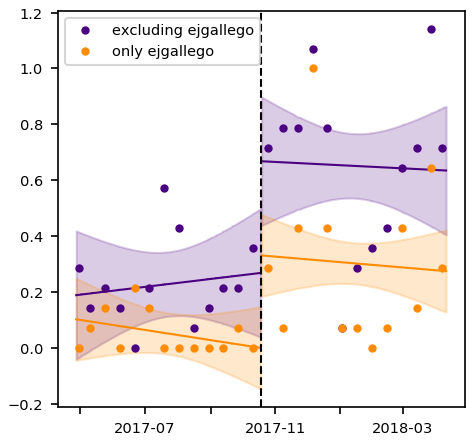

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.73 **   	(0.239)   	0.00228
after switch*reldate	 -0.000383      	(0.00227)   	0.866
reldate               	 -0.00013      	(0.000816)   	0.874
constant              	 0.269 ***  	(0.0809)   	0.000905


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.713 **   	(0.235)   	0.00245
after switch*reldate	 -0.000365      	(0.00222)   	0.87
reldate               	 -0.000302      	(0.000809)   	0.709
constant              	 0.231 **   	(0.0794)   	0.00369


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.0171      	(0.0442)   	0.6

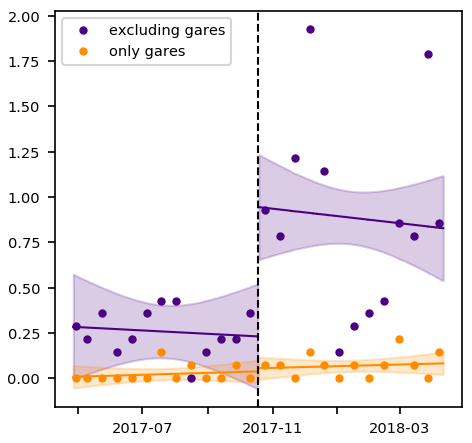

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.73 **   	(0.239)   	0.00228
after switch*reldate	 -0.000383      	(0.00227)   	0.866
reldate               	 -0.00013      	(0.000816)   	0.874
constant              	 0.269 ***  	(0.0809)   	0.000905


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.631 **   	(0.225)   	0.00498
after switch*reldate	 -0.000457      	(0.00218)   	0.834
reldate               	 -0.000343      	(0.000758)   	0.651
constant              	 0.233 **   	(0.0726)   	0.00134


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.0992      	(0.0713)   	0.

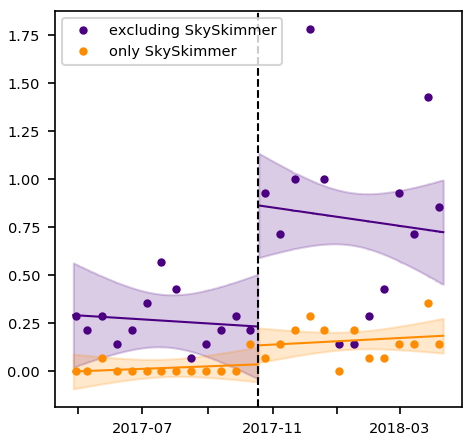

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.73 **   	(0.239)   	0.00228
after switch*reldate	 -0.000383      	(0.00227)   	0.866
reldate               	 -0.00013      	(0.000816)   	0.874
constant              	 0.269 ***  	(0.0809)   	0.000905


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.807 ***  	(0.238)   	0.000703
after switch*reldate	 -0.000157      	(0.00226)   	0.945
reldate               	 -0.000582      	(0.000799)   	0.466
constant              	 0.2 **   	(0.0775)   	0.00977


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 -0.0766 *    	(0.032)   	0.0

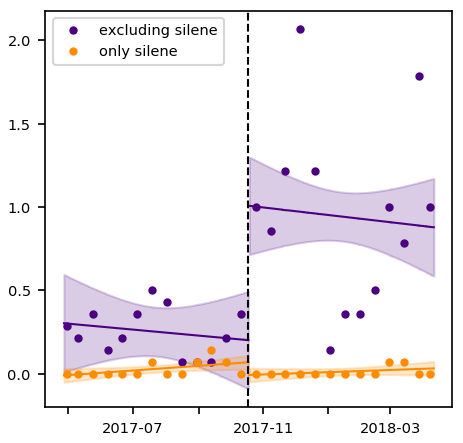

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.73 **   	(0.239)   	0.00228
after switch*reldate	 -0.000383      	(0.00227)   	0.866
reldate               	 -0.00013      	(0.000816)   	0.874
constant              	 0.269 ***  	(0.0809)   	0.000905


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.459 *    	(0.199)   	0.021
after switch*reldate	 0.00138      	(0.00192)   	0.473
reldate               	 -7.61e-05      	(0.000739)   	0.918
constant              	 0.21 **   	(0.0705)   	0.00284


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.271 **   	(0.0947)   	0.00418


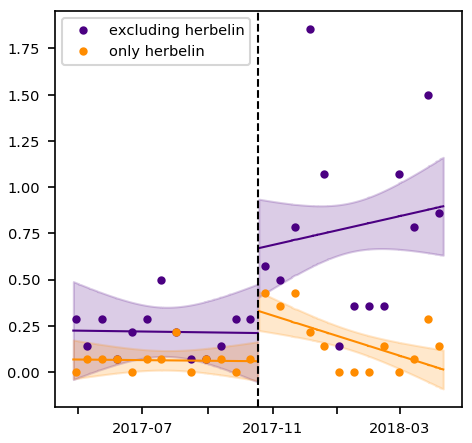

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.73 **   	(0.239)   	0.00228
after switch*reldate	 -0.000383      	(0.00227)   	0.866
reldate               	 -0.00013      	(0.000816)   	0.874
constant              	 0.269 ***  	(0.0809)   	0.000905


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.675 **   	(0.227)   	0.00291
after switch*reldate	 -0.000275      	(0.00217)   	0.899
reldate               	 -0.00013      	(0.000816)   	0.874
constant              	 0.269 ***  	(0.0809)   	0.000905


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.0551      	(0.0339)   	0.

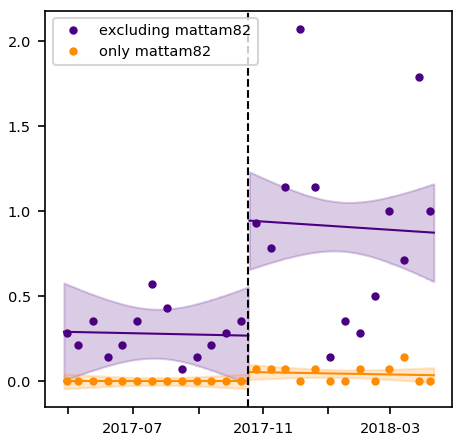

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.73 **   	(0.239)   	0.00228
after switch*reldate	 -0.000383      	(0.00227)   	0.866
reldate               	 -0.00013      	(0.000816)   	0.874
constant              	 0.269 ***  	(0.0809)   	0.000905


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.722 **   	(0.224)   	0.00124
after switch*reldate	 -0.00115      	(0.00208)   	0.579
reldate               	 -0.000322      	(0.000769)   	0.675
constant              	 0.223 **   	(0.073)   	0.00224


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.00805      	(0.0818)   	0.9

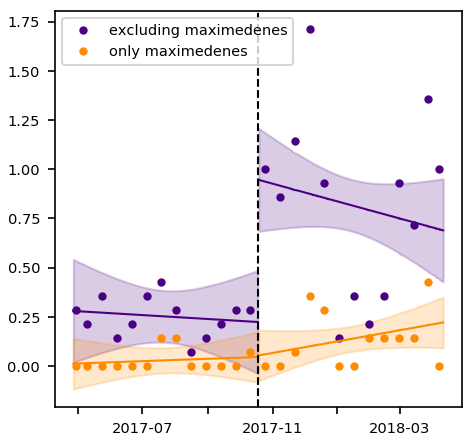

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.73 **   	(0.239)   	0.00228
after switch*reldate	 -0.000383      	(0.00227)   	0.866
reldate               	 -0.00013      	(0.000816)   	0.874
constant              	 0.269 ***  	(0.0809)   	0.000905


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.751 **   	(0.239)   	0.00167
after switch*reldate	 -0.000213      	(0.00227)   	0.925
reldate               	 -0.0003      	(0.000807)   	0.71
constant              	 0.248 **   	(0.0796)   	0.00184


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 -0.0207      	(0.0206)   	0.31

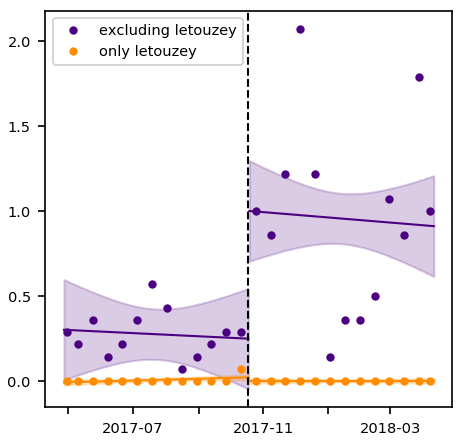

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.73 **   	(0.239)   	0.00228
after switch*reldate	 -0.000383      	(0.00227)   	0.866
reldate               	 -0.00013      	(0.000816)   	0.874
constant              	 0.269 ***  	(0.0809)   	0.000905


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.72 **   	(0.222)   	0.00118
after switch*reldate	 -0.00092      	(0.00211)   	0.663
reldate               	 0.000195      	(0.000707)   	0.783
constant              	 0.251 **   	(0.0766)   	0.00104


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.0101      	(0.0437)   	0.818

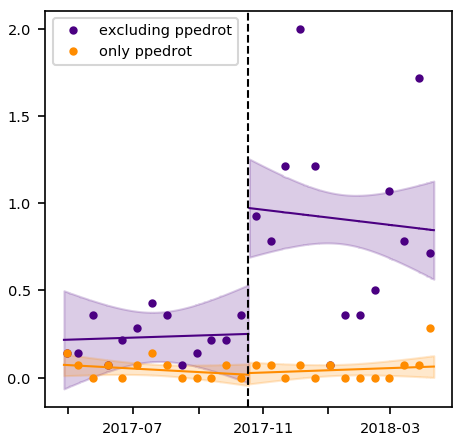

In [90]:
for dev in active_non_excluded_devs:
  hetero_analysis(issues_1D[dev],'count','issues by all developers',f'excluding {dev}',f'only {dev}',periods=175)

#### Number of distinct weekly developer-reporters

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.92 *    	(0.977)   	0.0493
after switch*reldate	 0.0162      	(0.0648)   	0.803
reldate               	 -0.00462      	(0.0378)   	0.903
constant              	 1.5 **   	(0.579)   	0.00955


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.32      	(0.955)   	0.167
after switch*reldate	 0.000769      	(0.0609)   	0.99
reldate               	 0.00769      	(0.0367)   	0.834
constant              	 1.46 *    	(0.603)   	0.0155


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.603 *    	(0.241)   	0.0123
after switch*reldate	

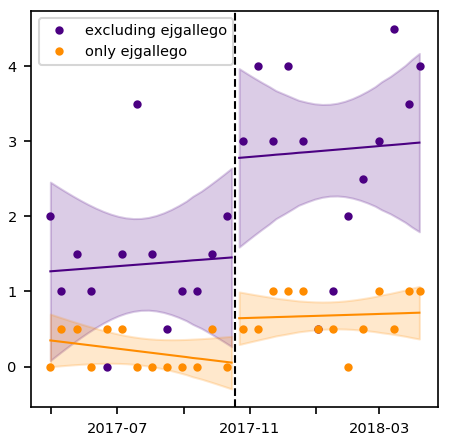

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.92 *    	(0.977)   	0.0493
after switch*reldate	 0.0162      	(0.0648)   	0.803
reldate               	 -0.00462      	(0.0378)   	0.903
constant              	 1.5 **   	(0.579)   	0.00955


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.78 *    	(0.855)   	0.0373
after switch*reldate	 0.0223      	(0.0609)   	0.714
reldate               	 -0.0131      	(0.0367)   	0.722
constant              	 1.23 *    	(0.548)   	0.0248


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.142      	(0.255)   	0.577
after switch*reldate	 

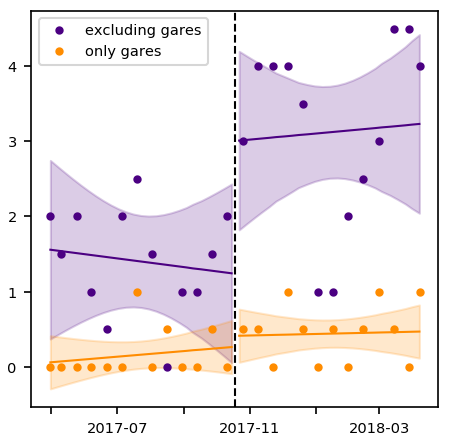

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.92 *    	(0.977)   	0.0493
after switch*reldate	 0.0162      	(0.0648)   	0.803
reldate               	 -0.00462      	(0.0378)   	0.903
constant              	 1.5 **   	(0.579)   	0.00955


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.38      	(0.816)   	0.0911
after switch*reldate	 0.0162      	(0.055)   	0.769
reldate               	 -0.00692      	(0.0322)   	0.83
constant              	 1.39 **   	(0.481)   	0.00384


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.542 *    	(0.229)   	0.0178
after switch*reldate	

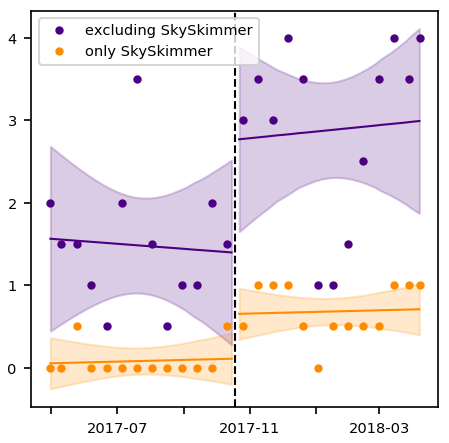

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.92 *    	(0.977)   	0.0493
after switch*reldate	 0.0162      	(0.0648)   	0.803
reldate               	 -0.00462      	(0.0378)   	0.903
constant              	 1.5 **   	(0.579)   	0.00955


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.36 *    	(0.972)   	0.0152
after switch*reldate	 0.0215      	(0.0629)   	0.732
reldate               	 -0.0215      	(0.0379)   	0.57
constant              	 1.12      	(0.579)   	0.0529


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 -0.438 *    	(0.191)   	0.0218
after switch*reldate	

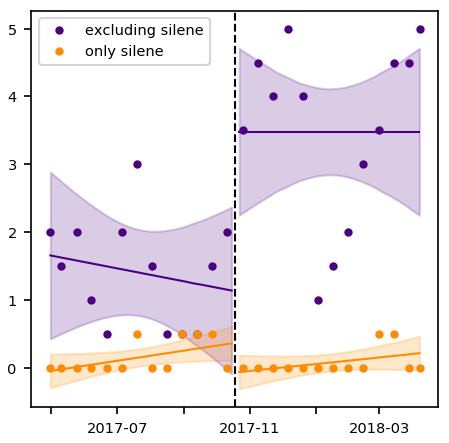

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.92 *    	(0.977)   	0.0493
after switch*reldate	 0.0162      	(0.0648)   	0.803
reldate               	 -0.00462      	(0.0378)   	0.903
constant              	 1.5 **   	(0.579)   	0.00955


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.37      	(0.898)   	0.127
after switch*reldate	 0.0323      	(0.0578)   	0.576
reldate               	 -0.00154      	(0.0309)   	0.96
constant              	 1.18 *    	(0.507)   	0.02


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.551 *    	(0.235)   	0.0191
after switch*reldate	 -0

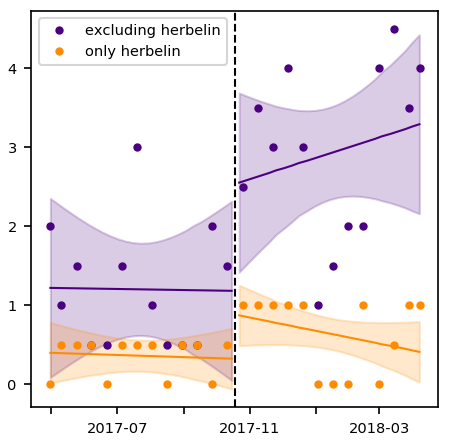

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.92 *    	(0.977)   	0.0493
after switch*reldate	 0.0162      	(0.0648)   	0.803
reldate               	 -0.00462      	(0.0378)   	0.903
constant              	 1.5 **   	(0.579)   	0.00955


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.5      	(0.889)   	0.0909
after switch*reldate	 0.0277      	(0.0581)   	0.633
reldate               	 -0.00462      	(0.0378)   	0.903
constant              	 1.5 **   	(0.579)   	0.00955


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.418 *    	(0.19)   	0.0274
after switch*reldate	 

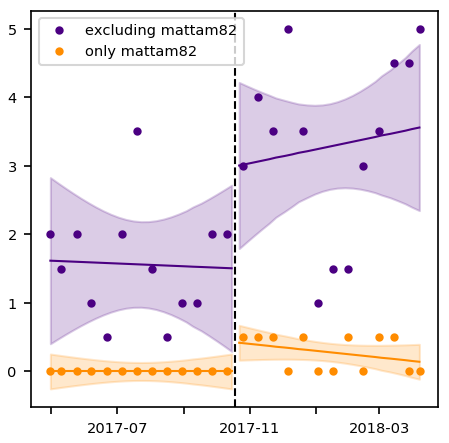

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.92 *    	(0.977)   	0.0493
after switch*reldate	 0.0162      	(0.0648)   	0.803
reldate               	 -0.00462      	(0.0378)   	0.903
constant              	 1.5 **   	(0.579)   	0.00955


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.09 *    	(0.89)   	0.0186
after switch*reldate	 -0.00231      	(0.0617)   	0.97
reldate               	 -0.0138      	(0.0334)   	0.678
constant              	 1.26 **   	(0.477)   	0.00822


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 -0.172      	(0.216)   	0.425
after switch*reldate

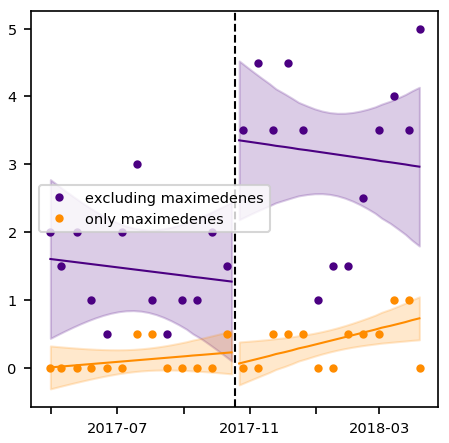

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.92 *    	(0.977)   	0.0493
after switch*reldate	 0.0162      	(0.0648)   	0.803
reldate               	 -0.00462      	(0.0378)   	0.903
constant              	 1.5 **   	(0.579)   	0.00955


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.07 *    	(0.924)   	0.025
after switch*reldate	 0.0246      	(0.0623)   	0.693
reldate               	 -0.0131      	(0.0334)   	0.695
constant              	 1.35 **   	(0.484)   	0.00532


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 -0.15      	(0.142)   	0.29
after switch*reldate	 -

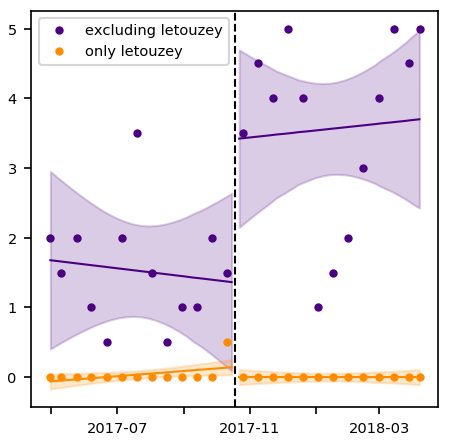

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.92 *    	(0.977)   	0.0493
after switch*reldate	 0.0162      	(0.0648)   	0.803
reldate               	 -0.00462      	(0.0378)   	0.903
constant              	 1.5 **   	(0.579)   	0.00955


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.76 *    	(0.841)   	0.0363
after switch*reldate	 -0.000769      	(0.054)   	0.989
reldate               	 0.0115      	(0.0337)   	0.732
constant              	 1.39 **   	(0.53)   	0.00872


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.161      	(0.26)   	0.537
after switch*reldate	 

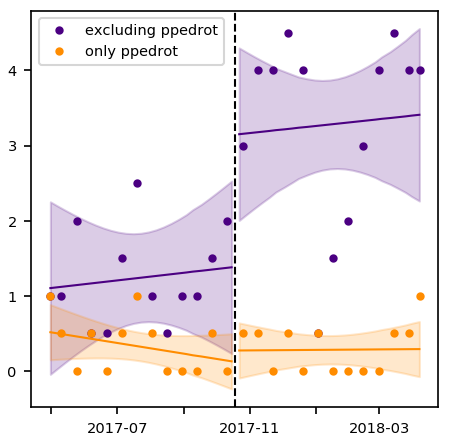

In [91]:
for dev in active_non_excluded_devs:
  hetero_analysis(issues_1W[dev],'author','distinct developer-reporters',f'excluding {dev}',f'only {dev}',periods=25)

The following shows that the result on the jump in the number of comments is not robust to the removal of the developer ejgallego, and the result on the number of distinct developer-commentators is not robust to the removal of the developer mattam82.

#### Number of comments by developers

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 4.63 *    	(1.83)   	0.0114
after switch*reldate	 0.0139      	(0.018)   	0.44
reldate               	 -0.00156      	(0.00685)   	0.82
constant              	 3.03 ***  	(0.708)   	1.89e-05


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.11      	(1.33)   	0.114
after switch*reldate	 0.00103      	(0.0126)   	0.935
reldate               	 0.00897      	(0.00505)   	0.0757
constant              	 3.03 ***  	(0.64)   	2.13e-06


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.52 **   	(0.826)   	0.00228
after switch*reldate

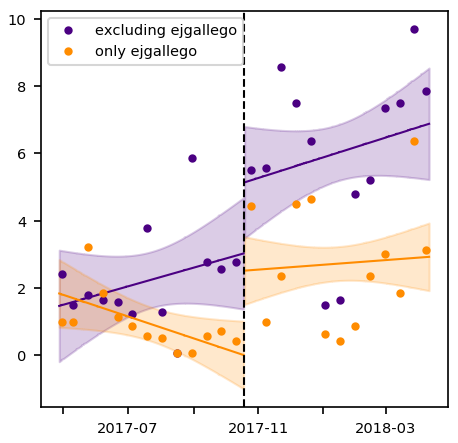

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 4.63 *    	(1.83)   	0.0114
after switch*reldate	 0.0139      	(0.018)   	0.44
reldate               	 -0.00156      	(0.00685)   	0.82
constant              	 3.03 ***  	(0.708)   	1.89e-05


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 4.82 **   	(1.76)   	0.00631
after switch*reldate	 0.00641      	(0.0168)   	0.703
reldate               	 -0.00191      	(0.0068)   	0.779
constant              	 2.88 ***  	(0.701)   	4.08e-05


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 -0.188      	(0.225)   	0.401
after switch*relda

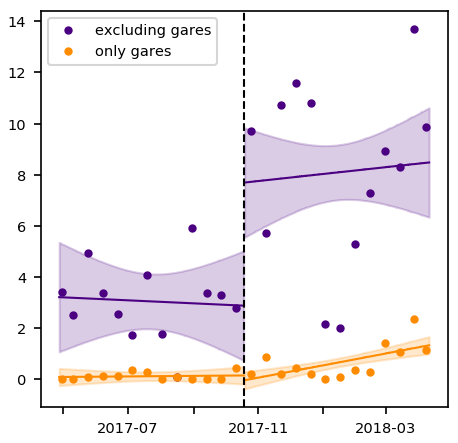

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 4.63 *    	(1.83)   	0.0114
after switch*reldate	 0.0139      	(0.018)   	0.44
reldate               	 -0.00156      	(0.00685)   	0.82
constant              	 3.03 ***  	(0.708)   	1.89e-05


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 3.94 *    	(1.71)   	0.0211
after switch*reldate	 0.0122      	(0.0168)   	0.466
reldate               	 -0.00248      	(0.00676)   	0.714
constant              	 2.9 ***  	(0.689)   	2.6e-05


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.691      	(0.446)   	0.121
after switch*reldate	 

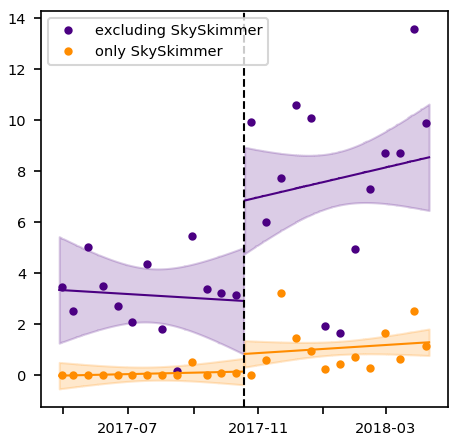

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 4.63 *    	(1.83)   	0.0114
after switch*reldate	 0.0139      	(0.018)   	0.44
reldate               	 -0.00156      	(0.00685)   	0.82
constant              	 3.03 ***  	(0.708)   	1.89e-05


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 5.23 **   	(1.78)   	0.00332
after switch*reldate	 0.0158      	(0.0177)   	0.372
reldate               	 -0.0038      	(0.00621)   	0.541
constant              	 2.41 ***  	(0.591)   	4.53e-05


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 -0.602 **   	(0.216)   	0.00527
after switch*reld

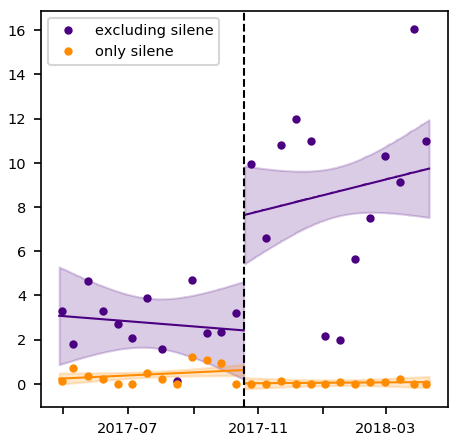

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 4.63 *    	(1.83)   	0.0114
after switch*reldate	 0.0139      	(0.018)   	0.44
reldate               	 -0.00156      	(0.00685)   	0.82
constant              	 3.03 ***  	(0.708)   	1.89e-05


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 3.91 *    	(1.55)   	0.0119
after switch*reldate	 0.0197      	(0.0157)   	0.211
reldate               	 -0.00464      	(0.00533)   	0.384
constant              	 2.13 ***  	(0.522)   	4.3e-05


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.716      	(0.456)   	0.117
after switch*reldate	

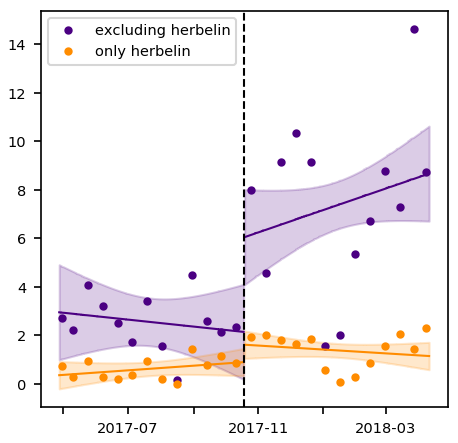

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 4.63 *    	(1.83)   	0.0114
after switch*reldate	 0.0139      	(0.018)   	0.44
reldate               	 -0.00156      	(0.00685)   	0.82
constant              	 3.03 ***  	(0.708)   	1.89e-05


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 4.07 *    	(1.74)   	0.0194
after switch*reldate	 0.0191      	(0.0174)   	0.272
reldate               	 -0.00315      	(0.00654)   	0.63
constant              	 2.73 ***  	(0.638)   	1.79e-05


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.559 *    	(0.256)   	0.029
after switch*reldate	

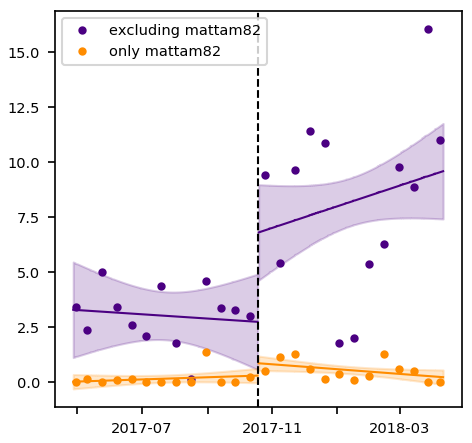

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 4.63 *    	(1.83)   	0.0114
after switch*reldate	 0.0139      	(0.018)   	0.44
reldate               	 -0.00156      	(0.00685)   	0.82
constant              	 3.03 ***  	(0.708)   	1.89e-05


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 4.53 **   	(1.62)   	0.0051
after switch*reldate	 0.00782      	(0.0158)   	0.62
reldate               	 -0.00335      	(0.00643)   	0.602
constant              	 2.49 ***  	(0.657)   	0.000147


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.0928      	(0.402)   	0.818
after switch*reldat

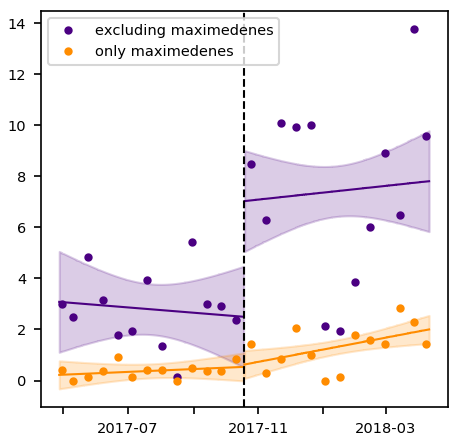

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 4.63 *    	(1.83)   	0.0114
after switch*reldate	 0.0139      	(0.018)   	0.44
reldate               	 -0.00156      	(0.00685)   	0.82
constant              	 3.03 ***  	(0.708)   	1.89e-05


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 4.78 **   	(1.82)   	0.00884
after switch*reldate	 0.0138      	(0.018)   	0.445
reldate               	 -0.00168      	(0.00679)   	0.804
constant              	 2.89 ***  	(0.697)   	3.49e-05


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 -0.15 *    	(0.0647)   	0.0203
after switch*relda

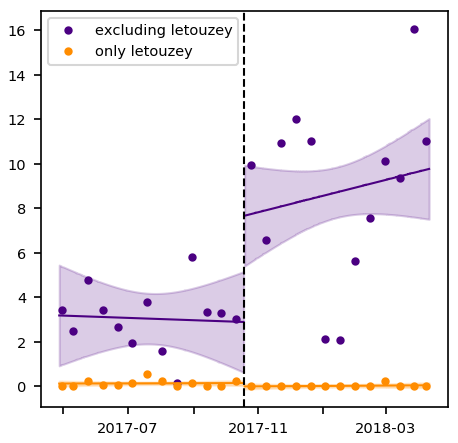

Outcome variable:	count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 4.63 *    	(1.83)   	0.0114
after switch*reldate	 0.0139      	(0.018)   	0.44
reldate               	 -0.00156      	(0.00685)   	0.82
constant              	 3.03 ***  	(0.708)   	1.89e-05


Outcome variable:	dev_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 3.86 *    	(1.66)   	0.0199
after switch*reldate	 0.0145      	(0.0167)   	0.384
reldate               	 -0.000833      	(0.00654)   	0.899
constant              	 2.75 ***  	(0.666)   	3.69e-05


Outcome variable:	other_count
No of observations:	350.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.769 *    	(0.315)   	0.0146
after switch*relda

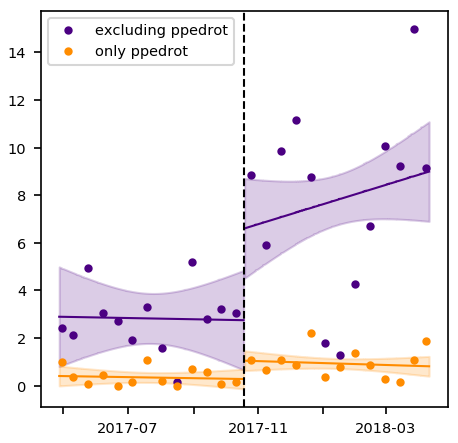

In [93]:
for dev in active_non_excluded_devs:
  hetero_analysis(comments_1D[dev],'count','comments by all developers',f'excluding {dev}',f'only {dev}',periods=175)

#### Number of distinct developer-commentators each week

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.53 *    	(1.05)   	0.0155
after switch*reldate	 0.0769      	(0.0641)   	0.23
reldate               	 -0.0469      	(0.0589)   	0.425
constant              	 3.83 ***  	(0.984)   	9.93e-05


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.21 *    	(0.928)   	0.0172
after switch*reldate	 0.0708      	(0.0568)   	0.213
reldate               	 -0.0408      	(0.0508)   	0.422
constant              	 3.15 ***  	(0.859)   	0.000243


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.32      	(0.19)   	0.0917
after switch*reldate	 

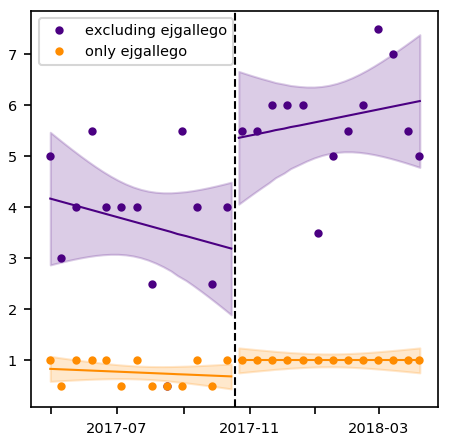

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.53 *    	(1.05)   	0.0155
after switch*reldate	 0.0769      	(0.0641)   	0.23
reldate               	 -0.0469      	(0.0589)   	0.425
constant              	 3.83 ***  	(0.984)   	9.93e-05


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2 *    	(0.97)   	0.0394
after switch*reldate	 0.0685      	(0.0594)   	0.249
reldate               	 -0.0408      	(0.054)   	0.45
constant              	 3.63 ***  	(0.924)   	8.61e-05


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.532 *    	(0.224)   	0.0176
after switch*reldate	 0.00

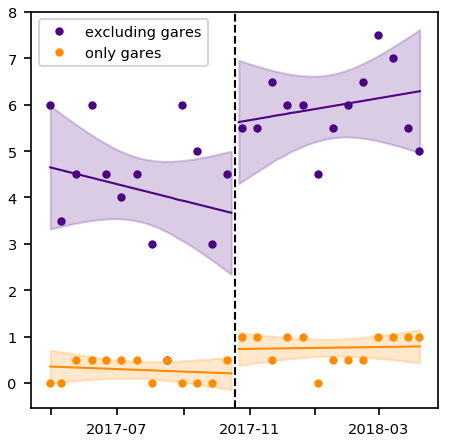

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.53 *    	(1.05)   	0.0155
after switch*reldate	 0.0769      	(0.0641)   	0.23
reldate               	 -0.0469      	(0.0589)   	0.425
constant              	 3.83 ***  	(0.984)   	9.93e-05


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.2 *    	(0.951)   	0.0205
after switch*reldate	 0.0792      	(0.0603)   	0.189
reldate               	 -0.0669      	(0.0538)   	0.214
constant              	 3.45 ***  	(0.868)   	6.99e-05


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.328      	(0.252)   	0.193
after switch*reldate	 

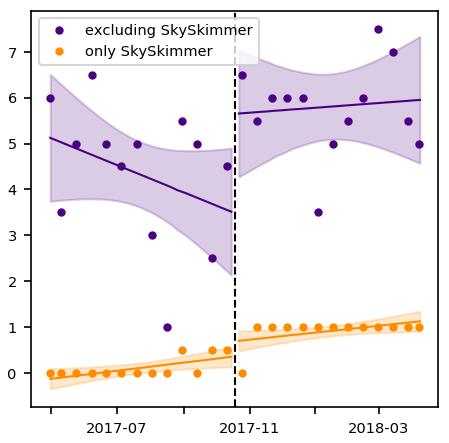

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.53 *    	(1.05)   	0.0155
after switch*reldate	 0.0769      	(0.0641)   	0.23
reldate               	 -0.0469      	(0.0589)   	0.425
constant              	 3.83 ***  	(0.984)   	9.93e-05


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.77 **   	(0.957)   	0.00374
after switch*reldate	 0.04      	(0.0602)   	0.507
reldate               	 -0.0262      	(0.0573)   	0.648
constant              	 3.54 ***  	(0.912)   	0.000104


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 -0.244      	(0.236)   	0.301
after switch*reldate	

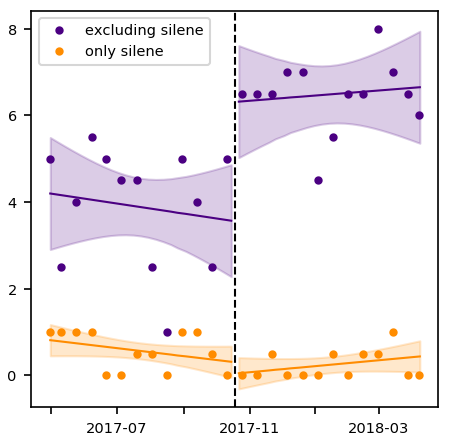

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.53 *    	(1.05)   	0.0155
after switch*reldate	 0.0769      	(0.0641)   	0.23
reldate               	 -0.0469      	(0.0589)   	0.425
constant              	 3.83 ***  	(0.984)   	9.93e-05


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.21 *    	(0.881)   	0.0121
after switch*reldate	 0.0662      	(0.056)   	0.237
reldate               	 -0.0369      	(0.0501)   	0.461
constant              	 3.24 ***  	(0.821)   	7.94e-05


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.321      	(0.219)   	0.143
after switch*reldate	 

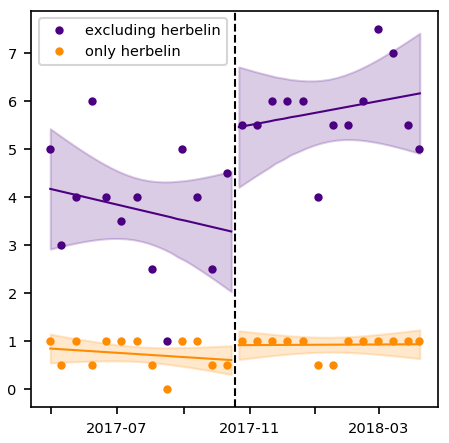

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.53 *    	(1.05)   	0.0155
after switch*reldate	 0.0769      	(0.0641)   	0.23
reldate               	 -0.0469      	(0.0589)   	0.425
constant              	 3.83 ***  	(0.984)   	9.93e-05


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 1.72      	(1.05)   	0.103
after switch*reldate	 0.105      	(0.0633)   	0.0983
reldate               	 -0.0485      	(0.0592)   	0.413
constant              	 3.57 ***  	(0.989)   	0.000308


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.814 ***  	(0.222)   	0.000248
after switch*reldate

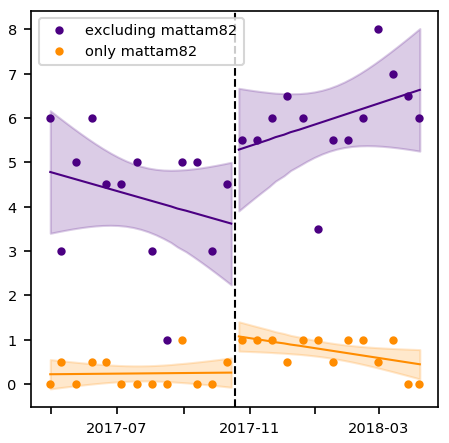

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.53 *    	(1.05)   	0.0155
after switch*reldate	 0.0769      	(0.0641)   	0.23
reldate               	 -0.0469      	(0.0589)   	0.425
constant              	 3.83 ***  	(0.984)   	9.93e-05


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.46 **   	(0.916)   	0.00723
after switch*reldate	 0.0738      	(0.0561)   	0.188
reldate               	 -0.0538      	(0.0493)   	0.275
constant              	 3.14 ***  	(0.842)   	0.000193


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.07      	(0.245)   	0.775
after switch*reldate	

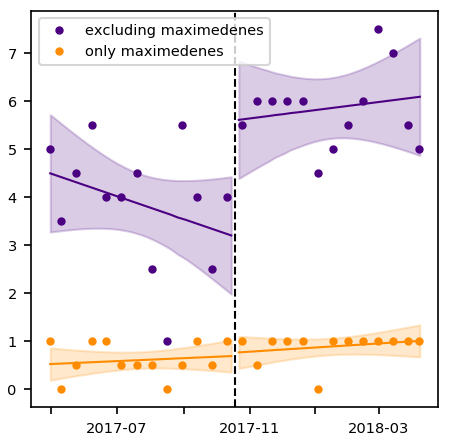

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.53 *    	(1.05)   	0.0155
after switch*reldate	 0.0769      	(0.0641)   	0.23
reldate               	 -0.0469      	(0.0589)   	0.425
constant              	 3.83 ***  	(0.984)   	9.93e-05


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.86 **   	(0.931)   	0.00211
after switch*reldate	 0.0646      	(0.0565)   	0.252
reldate               	 -0.0446      	(0.0518)   	0.389
constant              	 3.54 ***  	(0.865)   	4.27e-05


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 -0.33      	(0.188)   	0.0798
after switch*reldat

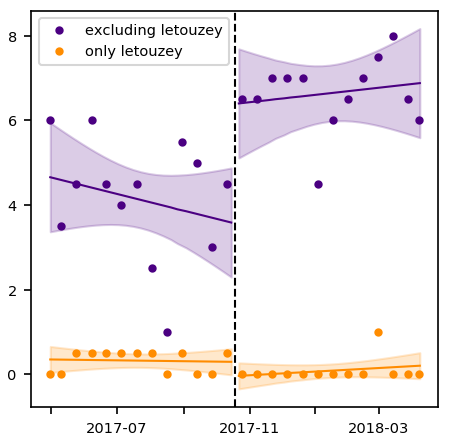

Outcome variable:	author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.53 *    	(1.05)   	0.0155
after switch*reldate	 0.0769      	(0.0641)   	0.23
reldate               	 -0.0469      	(0.0589)   	0.425
constant              	 3.83 ***  	(0.984)   	9.93e-05


Outcome variable:	dev_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 2.21 *    	(0.985)   	0.0247
after switch*reldate	 0.0608      	(0.0616)   	0.324
reldate               	 -0.0377      	(0.0564)   	0.504
constant              	 3.27 ***  	(0.924)   	0.0004


Outcome variable:	other_author
No of observations:	50.0
                      	coef		std err		P>|t|
-----------------------------------------------------------------
after switch          	 0.317      	(0.235)   	0.178
after switch*reldate	 0

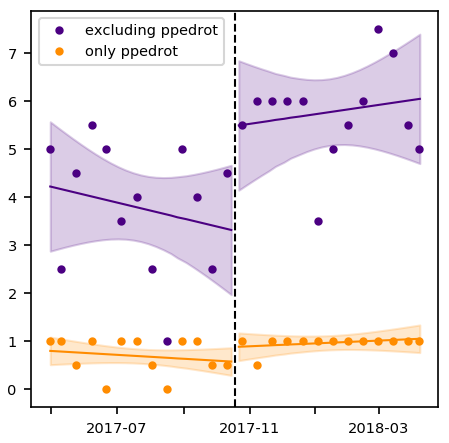

In [94]:
for dev in active_non_excluded_devs:
  hetero_analysis(comments_1W[dev],'author','distinct developer-commentators',f'excluding {dev}',f'only {dev}',periods=25)

### External validity

In this section, we look at another project that did a similar switch: Ledger.

Uncomment the following lines if you would like to fetch fresh data:

In [82]:
#fetch_issues('ledger',prefix='ledger_')
#fetch_issue_comments('ledger',prefix='ledger_')

In [83]:
ledger_issues = load_csv('ledger_issues.csv')
ledger_comments = load_csv('ledger_comments.csv')

File retrieved from local file system: ledger_issues.csv
File retrieved from local file system: ledger_comments.csv


We remove artefact migration comments.

In [84]:
ledger_comments = remove_migration_artifact_comments(ledger_issues,ledger_comments)

We group by periods. All the author information will be unusable because the Ledger migration did not preserve author information for users that could not be matched to a GitHub username.

In [85]:
bugzilla_crash_date = pd.datetime(2017,8,14)
ledger_switch_date = pd.datetime(2018,1,23)

_,ledger_issues_1D,_,_,ledger_issues_4W = df_1D_1W_2W_4W(ledger_issues,switch_date=ledger_switch_date)
_,ledger_comments_1D,_,_,ledger_comments_4W = df_1D_1W_2W_4W(ledger_comments,switch_date=ledger_switch_date)

In [86]:
def display_ledger_data(data_1D):
  plot_data = average(data_1D[(data_1D).index >= pd.datetime(2015,1,1)],'reldate_4W')

  _, ax = plt.subplots()

  plt.plot(plot_data['count'],'.',label='')

  mean_before = plot_data[plot_data.index < bugzilla_crash_date]['count'].mean()
  mean_after = plot_data[plot_data.index >= ledger_switch_date]['count'].mean()
  plt.hlines(mean_before,linestyles='dotted',xmin=pd.datetime(2015,1,1),xmax=bugzilla_crash_date)
  plt.hlines(mean_after,linestyles='dotted',xmin=ledger_switch_date,xmax=issues.index[-1])

  plt.axvline(x=bugzilla_crash_date,color='black',lw=1,label='Bugzilla tracker crashed')
  plt.axvline(x=ledger_switch_date,color='red',lw=1,label='GitHub tracker opened')
  plt.legend(loc='upper left')
    
  less_ticks(ax)

#### Number of issues

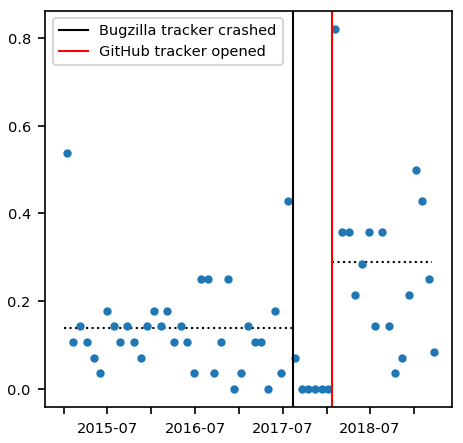

In [87]:
display_ledger_data(ledger_issues_1D)

#### Number of comments

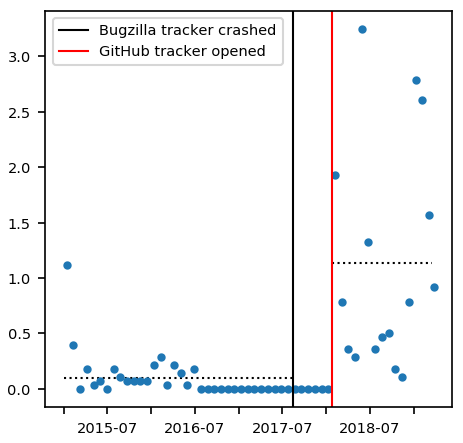

In [88]:
display_ledger_data(ledger_comments_1D)